# Graph theory

See https://github.com/multinetlab-amsterdam/network_TDA_tutorial/blob/main/1-network_analysis.ipynb for tutorial on network analysis

In [295]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import glob as glob
import pickle 
import func
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import normalize
from nilearn.plotting import find_probabilistic_atlas_cut_coords


In [296]:

def get_features(res_path, folder):
    path = glob.glob(os.path.join(res_path, folder, 'features*'))
    features = dict()
    keys = ['pre', 'post', 'contrast']
    for p, key in zip(path,keys):
        features[key] = np.load(p, allow_pickle=True)
    return features
def load_dict(p,folder, name):
    with open(os.path.join(p,folder, name), 'rb') as f:
        results = pickle.load(f)
    return results
def load_all(p, folder, atlas_name):
    atlas, atlas_labels, atlas_type, confounds = func.load_choose_atlas(atlas_name=atlas_name)

    results = load_dict(p, folder, 'dict_results.pkl')
    features = get_features(p, folder)
    return results, atlas, atlas_labels

p = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con'


results, atlas, labels = load_all(p, 'difumo64_tangentZ', 'difumo64')
#results, atlas, labels = load_all(p, 'difumo64_precision', 'difumo64')
#results, atlas, labels = load_all(p, 'yeo7_correlation', 'yeo_7')


Loading atlas:  difumo64


In [ ]:
results.keys()

In [ ]:
import numpy as np
np.unique(atlas.get_fdata(), return_counts=True)


In [297]:
pre_mean_connectome = results['pre_mean_connectome']
post_mean_connectome = results['post_mean_connectome']
pre_connectomes = results['pre_connectomes']
post_connectomes = results['post_connectomes']
print(pre_mean_connectome.min(), post_mean_connectome.min())
contrast_mean_connectome = results['zcontrast_mean_connectome']
print(contrast_mean_connectome.max(), contrast_mean_connectome.min())
zcontrast = contrast_mean_connectome 

-0.09702450511866395 -0.08859615378496309
0.05025576301256056 -0.05975336299290883


In [ ]:
# zeros for negatives edges
abs_pre_connectome = [np.maximum(connectome, 0) for connectome in results['pre_connectomes']]
abs_post_connectome = [np.maximum(connectome, 0) for connectome in results['post_connectomes']]
abs_mean_post = abs_post_connectomes.mean(axis=0)



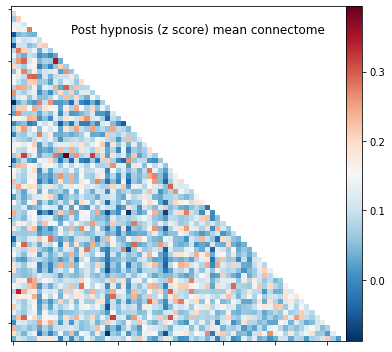

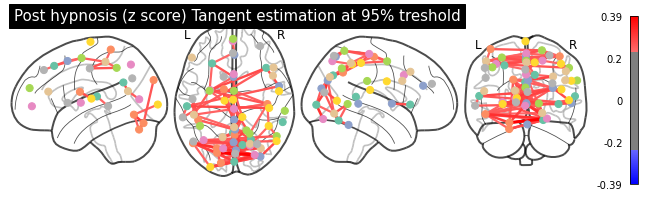

In [298]:
from nilearn import plotting

plotting.plot_matrix(
    results['post_mean_connectome'], colorbar=True, title = 'Post hypnosis (z score) mean connectome ', tri ='lower'
)

con_tresh = '95%'
cond = 'Post hypnosis (z score)'
cov_estim = 'Tangent estimation'
plotting.plot_connectome(
                results['post_mean_connectome'],
                find_probabilistic_atlas_cut_coords(atlas),
                edge_threshold=con_tresh,
                title=f"{cond} {cov_estim} at {con_tresh} treshold",
                display_mode="lzry",
                colorbar=True,
            )
plotting.show()

Find extreme values for tresholds

In [ ]:
# Histogram highest 5% values
import matplotlib.pyplot as plt
import numpy as np

# Flatten the connectivity matrix to a 1D array
edges_values = zcontrast.flatten()

# Plot the histogram of edges' values
plt.hist(edges_values, bins=50, color='blue', alpha=0.5)
plt.xlabel('Edge Values')
plt.ylabel('Frequency')
plt.title('Distribution of Connectivity Matrix Edges (corr. etim.; Z)')

# Find the threshold values at the 2.5% extremes
lower_threshold = np.percentile(edges_values, 2.5)
upper_threshold = np.percentile(edges_values, 95)

# Display the threshold values on the plot
plt.axvline(x=lower_threshold, color='red', linestyle='--', label='Lower Threshold (2.5%)')
plt.axvline(x=upper_threshold, color='green', linestyle='--', label='Upper Threshold (97.5%)')
plt.legend()

# Show the plot
plt.show()

# Print the threshold values
print("Lower Threshold (2.5%):", lower_threshold)
print("Upper Threshold (97.5%):", upper_threshold)

In [ ]:
#Hist highest 1% values
import matplotlib.pyplot as plt
import numpy as np

# Flatten the connectivity matrix to a 1D array
edges_values = zcontrast.flatten()

# Plot the histogram of edges' values
plt.hist(edges_values, bins=50, color='blue', alpha=0.5)
plt.xlabel('Edge Values')
plt.ylabel('Frequency')
plt.title('Distribution of Connectivity Matrix Edges (Tan. etim.; Z)')

# Find the lower and upper threshold values at the desired percentiles
lower_threshold = np.percentile(edges_values, 1)
upper_threshold = np.percentile(edges_values, 99)

# Display the threshold values on the plot
plt.axvline(x=lower_threshold, color='red', linestyle='--', label='Lower Threshold (1%)')
plt.axvline(x=upper_threshold, color='green', linestyle='--', label='Upper Threshold (99%)')
plt.legend()

# Show the plot
plt.show()

# Print the threshold values
print("Lower Threshold (1%):", lower_threshold)
print("Upper Threshold (99%):", upper_threshold)


## 2. post-pre contrast correlation (figures)

In [ ]:

# Define the absolute threshold values
positive_threshold =   upper_threshold
negative_threshold = lower_threshold

In [ ]:
zcontrast_thresholded = np.where(zcontrast >= positive_threshold, zcontrast, 0)
zcontrast_thresholded = np.where(zcontrast <= negative_threshold, zcontrast, zcontrast_thresholded)

# Get the indices of the significant labels based on the thresholds
significant_labels_indices = np.where(np.sum(np.abs(zcontrast_thresholded), axis=0) > 0)[0]
significant_labels = [labels[i] if i in significant_labels_indices else ' ' for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the figure size as needed
im = ax.imshow(zcontrast_thresholded, cmap='coolwarm')

# Set the tick labels and font size
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(significant_labels, fontsize=6)  # Adjust the label font size as desired
ax.set_yticklabels(significant_labels, fontsize=6)  # Adjust the label font size as desired

# Rotate the x-axis tick labels for better readability if needed
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# Create a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the title
ax.set_title('Hypnosis-induced change in connectivity (Z; Two-tailed 1%)')

# Show the plot
plt.show()

In [ ]:
zcontrast_thresholded = np.where(zcontrast >= positive_threshold, zcontrast, 0)
zcontrast_thresholded = np.where(zcontrast <= negative_threshold, zcontrast, zcontrast_thresholded)
significant_labels_indices = np.where(np.sum(np.abs(zcontrast_thresholded), axis=0) > 0)[0]

G = nx.Graph()
for i in significant_labels_indices:
    for j in range(i + 1, len(labels)):
        edge_weight = zcontrast_thresholded[i, j]
        if edge_weight != 0:
            G.add_edge(labels[i], labels[j], weight=edge_weight)

# Sort the edges based on their weights in descending order
sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Create a pandas DataFrame to store the pairs of nodes and connectivity change (z value)
data = {
    'Node Pair': [f"[{u} - {v}]" for u, v, _ in sorted_edges],
    'Connectivity Change (Z)': [data['weight'] for _, _, data in sorted_edges]
}

df = pd.DataFrame(data)
df.to_csv('connectivity_changes.csv', index=False)

plt.figure(figsize=(15, 6))
plt.bar(df['Node Pair'], df['Connectivity Change (Z)'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Node Pairs')
plt.ylabel('Connectivity Change (Z)')
plt.title('Edges with highest connectivity values (1% two-tailed)')
plt.tight_layout()

# Save the plot as an image
plt.savefig('connectivity_changes.png')

# Show the plot (optional)
plt.show()


In [ ]:
#Number of connections on matrix
# Create an empty graph
G = nx.Graph()

# Get the number of nodes in the matrix
num_nodes = zcontrast_thresholded.shape[0]

# Add nodes to the graph with labels
node_labels = [f"Node {i} ({labels[i]})" for i in range(num_nodes)]
G.add_nodes_from(range(num_nodes), label=node_labels)

# Iterate over the lower triangle of the thresholded matrix and add edges with non-zero values to the graph
for i in range(num_nodes):
    for j in range(i):  # Only iterate over the lower triangle
        edge_value = zcontrast_thresholded[i, j]
        if edge_value != 0 and labels[i] != ' ' and labels[j] != ' ':
            G.add_edge(i, j, weight=edge_value)

# Create a dictionary to store the number of non-empty connections for each node
non_empty_connections_dict = {node: 0 for node in G.nodes()}

# Count the number of non-empty connections for each node
for node in G.nodes():
    non_empty_connections = [1 for nbr in G[node] if G.nodes[nbr]['label'] != ' ']
    non_empty_connections_dict[node] = sum(non_empty_connections)

# Sort nodes based on the number of non-empty connections in descending order
sorted_nodes = sorted(non_empty_connections_dict.keys(), key=lambda x: non_empty_connections_dict[x], reverse=True)

# Print the nodes with their labels and the number of non-zero connections with non-empty labels
for node in sorted_nodes:
    if non_empty_connections_dict[node] >= 1:
        idx = int(node)
        print(f"{labels[idx]}: {non_empty_connections_dict[node]} non-zero connections")


In [ ]:
from nilearn import plotting 
import matplotlib.pyplot as plt

# change depending on atlas type
coords = plotting.find_probabilistic_atlas_cut_coords(atlas)
#coords = plotting.find_parcellation_cut_coords(atlas)
view = plotting.view_connectome(zcontrast_thresholded,coords, title = 'Change in connectivity (Z; 1% tresh.)')

output_file = "images/1imgs_difumo/contrast_correlation_viewcon.png"  # Specify the desired output file path and extension
#view.save_as_html(output_file)
view


In [ ]:
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import ttest_1samp

A = zcontrast
G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.Graph)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),labels)))
G.edges.data('weight')
edge_weights = G.edges.data('weight')



In [ ]:
#'Gbin' Binarized graph based on previous 1% threshold
# Apply the thresholds to the connectome matrix
zcontrast_binarized = np.where(np.abs(zcontrast_thresholded) > 0, 1, 0)

Gbin = nx.from_numpy_matrix(zcontrast_binarized)

# Assign node labels
labels_dict = {i: label for i, label in enumerate(significant_labels)}
nx.set_node_attributes(Gbin, labels_dict, 'label')

# Convert the edge weights to integers (0 or 1)
edge_weights_dict = {(u, v): int(weight) for u, v, weight in Gbin.edges(data='weight')}
nx.set_edge_attributes(Gbin, edge_weights_dict, 'weight')


In [ ]:
plt.figure(figsize=(14, 6))
pos = nx.spring_layout(Gbin, k=8)

# Extract edge weights
edge_weights = [data['weight'] for _, _, data in Gbin.edges(data=True)]

# Define colormap (you can adjust the colormap as needed)
cmap = plt.cm.binary

# Draw the graph with colored edges
nx.draw_networkx_nodes(Gbin, pos)
nx.draw_networkx_labels(Gbin, pos, font_size=10)
edge_colors = nx.draw_networkx_edges(Gbin, pos, edge_color=edge_weights, edge_cmap=cmap)

# Add color bar
cbar = plt.colorbar(edge_colors)
cbar.set_label('Edge Weight (0 or 1)')

save_path = os.path.join('images', 'binarized_graph.png')
plt.title('Binarized Graph with Edge Weights')
#plt.savefig(save_path)
plt.show()

In [ ]:
import matplotlib.cm as cm

# Collect node names for edges that meet the thresholds
nodes_to_keep = set()
for u, v, data in G.edges(data=True):
    if data['weight'] <= negative_threshold or data['weight'] >= positive_threshold:
        nodes_to_keep.add(u)
        nodes_to_keep.add(v)

# Create a subgraph with the filtered nodes
H = G.subgraph(nodes_to_keep)


plt.figure(figsize=(14, 6))
pos = nx.spring_layout(H, k=8)

# Extract edge weights
edge_weights = [data['weight'] for _, _, data in H.edges(data=True)]
min_edge_weight = min(edge_weights)
max_edge_weight = max(edge_weights)

# Define colormap
cmap = cm.get_cmap('cool')  # Choose a colormap

# Draw the subgraph with colored edges
nx.draw_networkx_nodes(H, pos)
nx.draw_networkx_labels(H, pos, font_size=10)
edge_colors = nx.draw_networkx_edges(H, pos, edge_color=edge_weights, edge_cmap=cmap)

# Add color bar
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_edge_weight, vmax=max_edge_weight))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Edge Weight')

save_path = os.path.join('images', 'contrast_correlation_graph.png')
plt.title('Post-pre correlation (Z values) Graph')
plt.savefig(save_path)
plt.show()

Graph metrics

In [ ]:
# (TangentZ) Mean graph DEGREE
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

# Compute the degree of the graph
degree = dict(G.degree(weight='weight'))

# Sort the nodes by degree (highest to lowest)
sorted_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)

# Get the highest 5% of nodes and their degree values
top_5_percent = int(len(sorted_degree) * 0.10)
highest_nodes = sorted_degree[:top_5_percent]

# Print all nodes and their degree values
print("Nodes sorted by degree (highest to lowest):")
for node_label, deg in sorted_degree:
    print(f"{node_label}: {deg}")
# Print the threshold value
threshold = highest_nodes[-1][1]
print(f"Threshold (highest 10%): {threshold}")

data = {
    'Node': [f"{node_label}" for node_label, deg in sorted_degree],
    'Degree': [deg for node_label, deg in sorted_degree],
}

df = pd.DataFrame(data)
#df.to_csv('connectivity_changes.csv', index=False)

plt.figure(figsize=(15, 6))
plt.bar(df['Node'], df['Degree'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Node')
plt.ylabel('Node Degree')
plt.title('Nodes degrees')
plt.tight_layout()

plt.show()
#------------------
# Degree Histogram
sns.distplot(list(degree.values()), kde=False, norm_hist=False)
plt.xlabel('Degree Values')
plt.ylabel('Counts')
plt.show()

# Plot the graph with degree values as the node markers
coords = plotting.find_probabilistic_atlas_cut_coords(atlas) 

# Plot the marker plot with all nodes
plt.figure(figsize=(8, 6))
plotting.plot_markers([degree[node] for node in G.nodes], coords, title='Node degrees - All Nodes', display_mode='lyrz')
plt.show()

# Replace degree values below threshold with 0
for node_label, deg in degree.items():
    if deg < threshold:
        degree[node_label] = 0

# Plot the marker plot with only nodes above the threshold
plt.figure(figsize=(8, 6))
plotting.plot_markers([degree[node] for node in G.nodes], coords, title='Node degrees - Nodes above Threshold (10%; 6/64 nodes)', display_mode='lyrz')
plt.show()



In [ ]:
#betweness Centralities plots
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

# The function accepts a argument 'distance' that, in correlation-based networks, must be seen as the inverse ... 
# of the weight value. Thus, a high correlation value (e.g., 0.8) means a shorter distance (i.e., 0.2).
G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, G_distance_dict, 'distance')

betweenness = nx.betweenness_closeness(G, weight='distance')
nx.set_node_attributes(G, betweenness, 'betwcloseness')

# Sort the nodes by betweenness closeness (highest to lowest)
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

# Get the highest 5% of nodes and their closeness values
top_10_percent = int(len(sorted_betweenness) * 0.10)
highest_nodes = sorted_betweenness[:top_10_percent]

# Print all nodes and their betweenness closeness values
print("Nodes sorted by betweenness closeness (highest to lowest):")
for node_label, closeness in sorted_betweenness:
    print(f"{node_label}: {closeness}")

# Print the threshold value
threshold = highest_nodes[-1][1]
print(f"Threshold (highest 10%): {threshold}")

data = {
    'Node': [f"{node_label}" for node_label, cent in sorted_betweenness],
    'closeness (betweenness)': [closeness for node, closeness in sorted_betweenness],
}
df = pd.DataFrame(data)
#--Distribution of betweenness closeness values over barplot
plt.figure(figsize=(15, 6))
plt.bar(df['Node'], df['closeness (betweenness)'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nodes')
plt.ylabel('Centralities (betweenness)')
plt.title('Centralities (betweenness)')
plt.tight_layout()
plt.show()

#---
threshold = highest_nodes[-1][1]
print(f"Threshold (highest 5%): {threshold}")

# betweenness closeness Histogram
sns.distplot(list(betweenness.values()), kde=False, norm_hist=False)
plt.xlabel('closeness values')
plt.ylabel('Counts')

# Plot the highest 5% values on the histogram
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold (highest 5%)')
plt.legend()
plt.show()

# Plot the graph with betweenness closeness values as the node markers
coords = plotting.find_probabilistic_atlas_cut_coords(atlas) 

# Plot the marker plot with all nodes
plt.figure(figsize=(8, 6))
plotting.plot_markers([betweenness[node] for node in G.nodes], coords, title='Node closeness (betweeness) - All Nodes', display_mode='lyrz')
plt.show()

# Replace closeness values below threshold with 0
for node_label, closeness in betweenness.items():
    if closeness < threshold:
        betweenness[node_label] = 0

# Plot the marker plot with only nodes above the threshold
plt.figure(figsize=(8, 6))
plotting.plot_markers([betweenness[node] for node in G.nodes], coords, title='Node centralities (betweeness) - Nodes above Threshold (10%; 6/64 nodes)',  display_mode='lyrz')
plt.show()


In [ ]:
#closeness Centralities plots
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

# The function accepts a argument 'distance' that, in correlation-based networks, must be seen as the inverse ... 
# of the weight value. Thus, a high correlation value (e.g., 0.8) means a shorter distance (i.e., 0.2).
G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, G_distance_dict, 'distance')
closeness = nx.closeness_centrality(G,distance='distance' )
nx.set_node_attributes(G, closeness, 'closecent')

# Sort the nodes by closeness closeness (highest to lowest)
sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

# Get the highest 5% of nodes and their closeness values
top_5_percent = int(len(sorted_closeness) * 0.10)
highest_nodes = sorted_closeness[:top_5_percent]

print("Nodes sorted by closeness closeness (highest to lowest):")
for node_label, closeness in sorted_closeness:
    print(f"{node_label}: {closeness}")

data = {
    'Node': [f"{node_label}" for node_label, cent in sorted_closeness],
    'closeness (closeness)': [closeness for node, closeness in sorted_closeness],
}
df = pd.DataFrame(data)
#df.to_csv('connectivity_changes.csv', index=False)
plt.figure(figsize=(15, 6))
plt.bar(df['Node'], df['closeness (closeness)'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Node')
plt.ylabel('Centralities (closeness)')
plt.title('Centralities (closeness)')
plt.tight_layout()

plt.show()


# Print the threshold value
threshold = highest_nodes[-1][1]
print(f"Threshold (highest 5%): {threshold}")

# Closeness closeness Histogram
sns.distplot(list(closeness.values()), kde=False, norm_hist=False)
plt.xlabel('closeness Values')
plt.ylabel('Counts')

# Plot the highest 5% values on the histogram
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold (highest 5%)')
plt.legend()
plt.show()

# Plot the graph with closeness centrality values as the node markers
coords = plotting.find_probabilistic_atlas_cut_coords(atlas) 

# Plot the marker plot with all nodes
plt.figure(figsize=(8, 6))
plotting.plot_markers([closeness[node] for node in G.nodes], coords, title='Node Closeness centrality - All Nodes', display_mode='lyrz')
plt.show()

# Replace closeness centrality values below threshold with 0
for node_label, centrality in closeness.items():
    if centrality < threshold:
        closeness[node_label] = 0

# Plot the marker plot with only nodes above the threshold
plt.figure(figsize=(8, 6))
plotting.plot_markers([closeness[node] for node in G.nodes], coords, title='Node\'s Closeness centralities - above Threshold (10%; 6/64 nodes)',  display_mode='lyrz')
plt.show()


In [ ]:
#Clustering coefficient
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

# Clustering Coefficient Calculation
clustering = nx.clustering(G, weight='weight')
nx.set_node_attributes(G, clustering, 'cc')

# Sort the nodes by clustering coefficient (highest to lowest)
sorted_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True)

# Get the highest 5% of nodes and their clustering coefficients
top_5_percent = int(len(sorted_clustering) * 0.10)
highest_nodes = sorted_clustering[:top_5_percent]

# Print all nodes and their clustering coefficients
print("Nodes sorted by clustering coefficient (highest to lowest):")
for node_label, cc in sorted_clustering:
    print(f"{node_label}: {cc}")

data = {
    'Node': [f"{node_label}" for node_label, clust in sorted_clustering],
    'Clustering coefficient': [clust for node, clust in sorted_clustering],
}
df = pd.DataFrame(data)
#df.to_csv('connectivity_changes.csv', index=False)
plt.figure(figsize=(15, 6))
plt.bar(df['Node'], df['Clustering coefficient'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Node')
plt.ylabel('Clustering coefficients')
plt.title('Clustering coefficients of all nodes')
plt.tight_layout()

plt.show()

# Print the threshold value
threshold = highest_nodes[-1][1]
print(f"Threshold (highest 5%): {threshold}")

# Clustering Coefficient Histogram
plt.figure(figsize=(8, 6))
sns.distplot(list(clustering.values()), kde=False, norm_hist=False)
plt.xlabel('Clustering Coefficient')
plt.ylabel('Counts')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold (highest 5%)')
plt.legend()
plt.title('Clustering Coefficient Distribution')
plt.show()

# Plot the graph with clustering coefficients as the node markers
coords = plotting.find_probabilistic_atlas_cut_coords(atlas) 

# Plot the marker plot with all nodes
plt.figure(figsize=(8, 6))
plotting.plot_markers([clustering[node] for node in G.nodes], coords, title='Node Clustering Coefficients - All Nodes',  display_mode='lyrz')
plt.show()

# Replace clustering coefficients values below threshold with 0
for node_label, cc in clustering.items():
    if cc < threshold:
        clustering[node_label] = 0

# Plot the marker plot with only nodes above the threshold
plt.figure(figsize=(8, 6))
plotting.plot_markers([clustering[node] for node in G.nodes], coords, title='Node Clustering Coefficients - above Threshold (10%; 6/64 nodes)',  display_mode='lyrz')
plt.show()


## 2.1 Intersubject predictions (correlation)

Producing Y having columns : ["total_chge_pain_hypAna", "Chge_hypnotic_depth", "Mental_relax_absChange", "Abs_diff_automaticity"]

In [616]:
# dependant variables 
xlsx_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\test_dataset\test_data_ASL\Hypnosis_variables_20190114_pr_jc.xlsx'
rawY = pd.read_excel(xlsx_path, sheet_name=0, index_col=1, header=2).iloc[2:, [4, 17,18, 19, 38, 48,65, 67]]
rawY.columns= ['SHSS_score', 'raw_change_ANA','raw_change_HYPER', "total_chge_pain_hypAna", "Chge_hypnotic_depth", "Mental_relax_absChange", 'Automaticity_post_ind',"Abs_diff_automaticity"]

cleanY = rawY.iloc[:-6,:] # remove sub04, sub34 and last 6 rows
cutY = cleanY.drop(['APM04*', 'APM34*'])

filledY = cutY.fillna(cutY.astype(float).mean()).astype(float)
filledY['SHSS_groups'] = pd.cut(filledY['SHSS_score'], bins=[0, 4, 8, 12], labels=['0', '1', '2']) # encode 3 groups for SHSS scores


#bin_edges = np.linspace(min(data_column), max(data_column), 4) # 4 bins
filledY['auto_groups'] = pd.cut(filledY['Abs_diff_automaticity'],
                               bins=np.linspace(min(filledY['Abs_diff_automaticity'])
                               - 1e-10,
                                                max(filledY['Abs_diff_automaticity']) + 1e-10, 4),
                               labels=['0', '1', '2'])

# reorder to match order on elm server e.i. ENV of server used to run analyses!
new_order = ['APM01', 'APM16', 'APM06', 'APM38', 'APM12', 'APM03', 'APM07', 'APM28', 'APM29', 'APM17', 'APM11', 'APM02',
             'APM15', 'APM05', 'APM32', 'APM42', 'APM35', 'APM43', 'APM41', 'APM08', 'APM36', 'APM27', 'APM33', 'APM22',
             'APM20', 'APM09', 'APM37', 'APM26', 'APM47', 'APM46', 'APM40']
#reorder to match elm server order
Y = pd.DataFrame(columns=filledY.columns)
for name in new_order:
    row = filledY.loc[name]
    Y.loc[name] = row

# List of target columns for prediction
target_columns = ['SHSS_score', 'raw_change_ANA', 'raw_change_HYPER', "total_chge_pain_hypAna", "Chge_hypnotic_depth", "Mental_relax_absChange", "Abs_diff_automaticity"]

Value: 0, Count: 8
Value: 1, Count: 15
Value: 2, Count: 8


(array([ 8.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  8.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

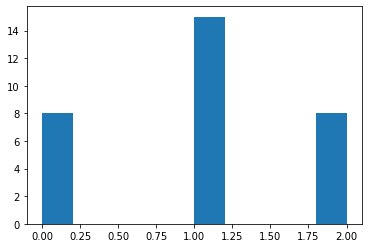

In [617]:
# Diff automaticity distribution
filledY['auto_groups'] = pd.to_numeric(filledY['auto_groups'], errors='coerce')
unique_values, value_counts = np.unique(filledY['auto_groups'], return_counts=True)

for value, count in zip(unique_values, value_counts):
    print(f"Value: {value}, Count: {count}")
plt.hist(filledY['auto_groups'])


======= SHSS_score =======


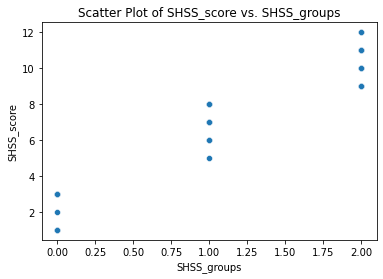

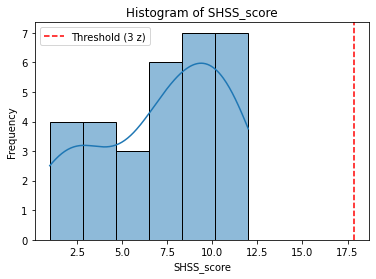

No extreme scores found.
-------------------


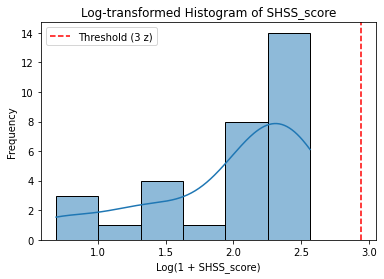

======= raw_change_ANA =======


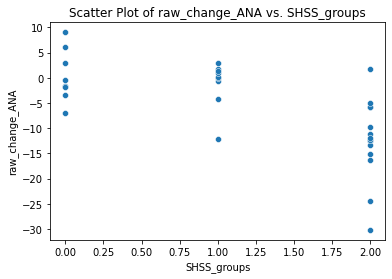

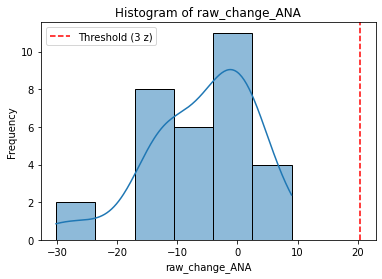

No extreme scores found.
-------------------


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


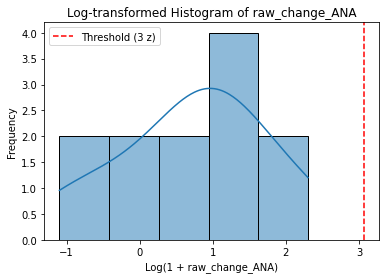

======= raw_change_HYPER =======


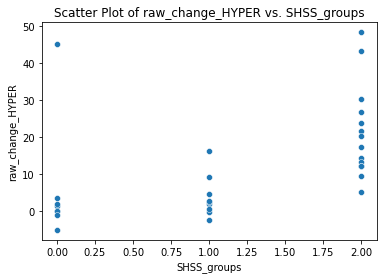

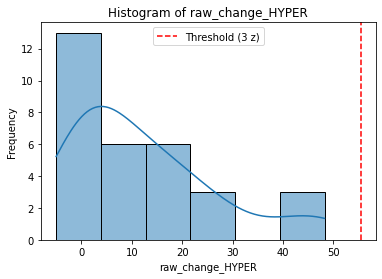

No extreme scores found.
-------------------


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


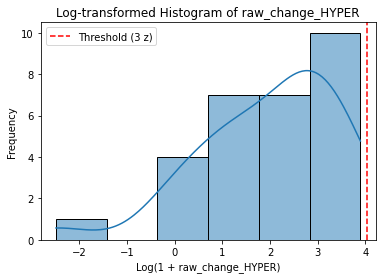

======= total_chge_pain_hypAna =======


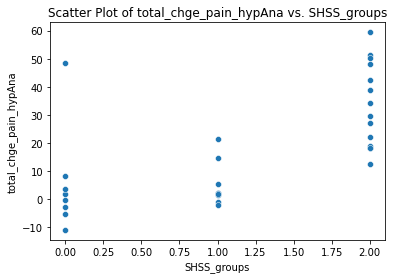

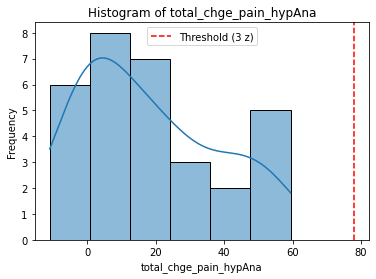

No extreme scores found.
-------------------


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


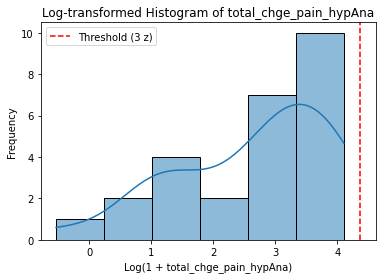

======= Chge_hypnotic_depth =======


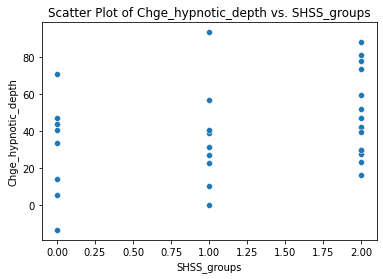

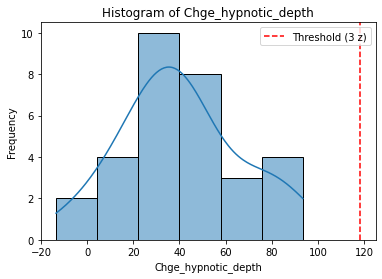

No extreme scores found.
-------------------


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


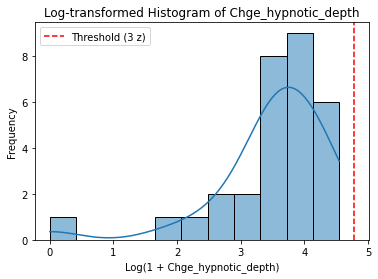

======= Mental_relax_absChange =======


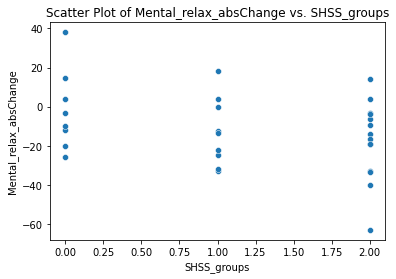

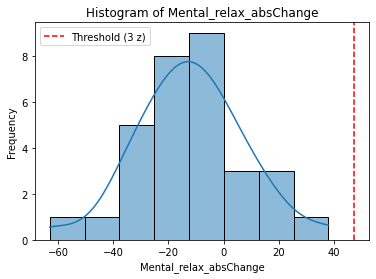

No extreme scores found.
-------------------


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


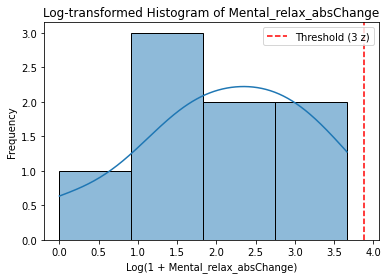

======= Automaticity_post_ind =======


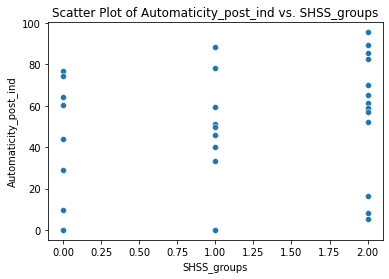

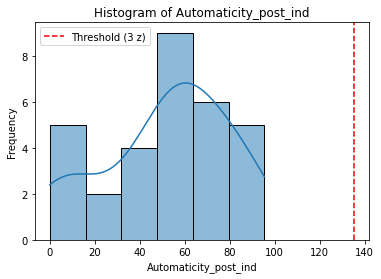

No extreme scores found.
-------------------


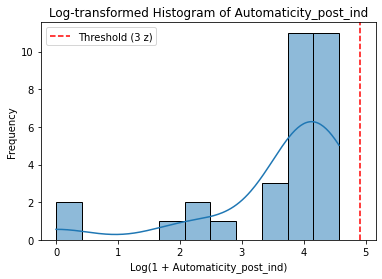

======= Abs_diff_automaticity =======


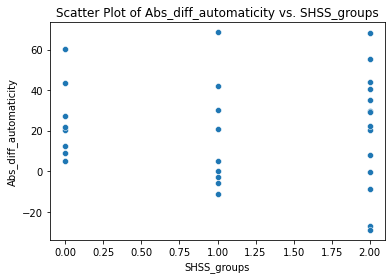

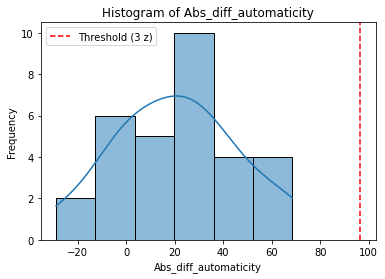

No extreme scores found.
-------------------


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


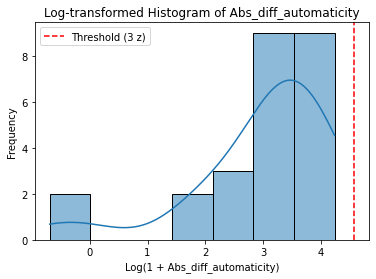

======= SHSS_groups =======


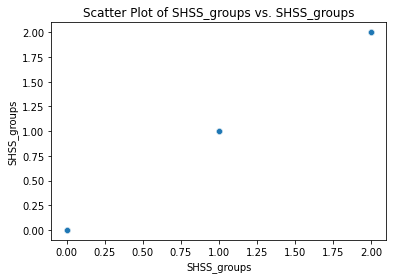

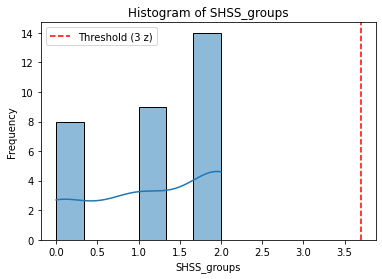

No extreme scores found.
-------------------


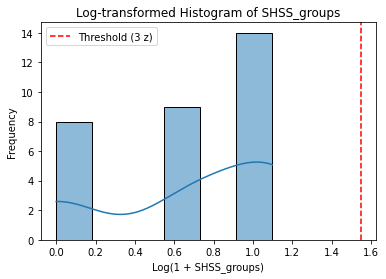

======= auto_groups =======


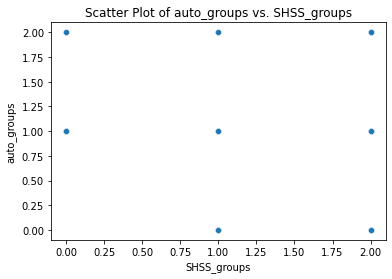

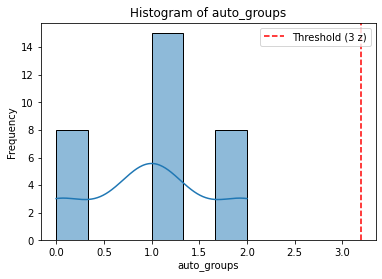

No extreme scores found.
-------------------


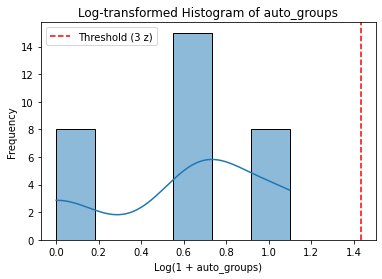

In [633]:
# check linearity of VD
Y = Y.apply(pd.to_numeric, errors='coerce')
Y = Y.dropna()
# Compute z-scores for each dependent variable
z_scores = (Y - Y.mean()) / Y.std()
# Set the threshold for extreme scores
z_threshold = 3
# Iterate through each dependent variable
for column in Y.columns:
    print(f"======= {column} =======")

    # Scatter plot of the dependent variable against SHSS_groups
    sns.scatterplot(data=Y, x='SHSS_groups', y=column)
    plt.xlabel('SHSS_groups')
    plt.ylabel(column)
    plt.title(f"Scatter Plot of {column} vs. SHSS_groups")
    plt.show()

    # Histogram of the dependent variable
    sns.histplot(Y[column], kde=True)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f"Histogram of {column}")
    plt.axvline(x=Y[column].mean() + z_threshold * Y[column].std(), color='red', linestyle='--', label=f'Threshold ({z_threshold} z)')
    plt.legend()
    plt.show()

    # Check for extreme scores with z values > 3
    extreme_scores = Y[np.abs(z_scores[column]) > z_threshold]
    if len(extreme_scores) > 0:
        print(f"Extreme Scores (> {z_threshold} z) for {column}:")
        print(extreme_scores)
    else:
        print("No extreme scores found.")

    print("-------------------")

    # Log-transformed histogram
    log_transformed_column = np.log1p(Y[column])
    sns.histplot(log_transformed_column, kde=True)
    plt.xlabel(f'Log(1 + {column})')
    plt.ylabel('Frequency')
    plt.title(f"Log-transformed Histogram of {column}")
    plt.axvline(x=np.log1p(Y[column].mean() + z_threshold * Y[column].std()), color='red', linestyle='--', label=f'Threshold ({z_threshold} z)')
    plt.legend()
    plt.show()


Initializing dict (Gs) with each subject's graph (len 31)

In [619]:
# Single-subject graphs
print(results.keys())
As = [results['contrast_connectomes'][i] for i in range(len(results['contrast_connectomes']))]

rawGs = {nx.from_numpy_matrix(A, create_using=nx.Graph) for A in As}
rawGs = {nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),labels))) for G in rawGs}

# add keys to make it a dict instead od a set
Gs = dict()
for name, G in zip(Y.index,rawGs): 
    Gs[name] = G
    #Gs[].edges(data=True)
print(Gs)


dict_keys(['pre_series', 'post_series', 'seed_pre_series', 'seed_post_series', 'seed_to_pre_correlations', 'seed_to_post_correlations', 'pre_connectomes', 'pre_mean_connectome', 'post_connectomes', 'post_mean_connectome', 'zcontrast_mean_connectome', 'contrast_connectomes', 'mean_seed_pre_connectome', 'mean_seed_post_connectome', 'mean_seed_contrast_connectome', 'preX', 'postX', 'contrastX'])
{'APM01': <networkx.classes.graph.Graph object at 0x000001E17CD19840>, 'APM16': <networkx.classes.graph.Graph object at 0x000001E17CD18130>, 'APM06': <networkx.classes.graph.Graph object at 0x000001E17CD18940>, 'APM38': <networkx.classes.graph.Graph object at 0x000001E17CD1B160>, 'APM12': <networkx.classes.graph.Graph object at 0x000001E17CD1A1A0>, 'APM03': <networkx.classes.graph.Graph object at 0x000001E1140349D0>, 'APM07': <networkx.classes.graph.Graph object at 0x000001E17CD19A20>, 'APM28': <networkx.classes.graph.Graph object at 0x000001E17CD1A230>, 'APM29': <networkx.classes.graph.Graph obje

Degree and centralities per participant's graph

In [440]:
for participant, graph in Gs.items():
    strength = graph.degree(weight='weight')
    strengths = {node: val for (node, val) in strength}
    nx.set_node_attributes(graph, strengths, 'strength')
    norm_strengths = {node: val * 1/(len(graph.nodes)-1) for (node, val) in strength}
    nx.set_node_attributes(graph, norm_strengths, 'strengthnorm')

# Degree centrality
for participant, G in Gs.items():
    degree = nx.degree_centrality(G)
    nx.set_node_attributes(G, degree, 'degCentrality')

# betweenness centrality
for participant, G in Gs.items():
    G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}
    nx.set_edge_attributes(G, G_distance_dict, 'distance')
    closeness = nx.betweenness_centrality (G, weight='distance')
    # Now we add the closeness closeness value as an attribute to the nodes
    nx.set_node_attributes(G, closeness, 'betCentrality')

# closeness centrality
for participant, G in Gs.items():
    G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}
    nx.set_edge_attributes(G, G_distance_dict, 'distance')
    closeness = nx.closeness_centrality (G, distance='distance')
    # Now we add the closeness closeness value as an attribute to the nodes
    nx.set_node_attributes(G, closeness, 'closecent')


for participant, graph in Gs.items():
    # Compute the clustering coefficient
    clust = nx.clustering(graph, weight='weight')
    # Add the clustering coefficient as a node attribute
    nx.set_node_attributes(graph, clust, 'clustering')

Creating X_degree feature matrix of shape N x nb. nodes : 31 x 64

In [612]:
participant_names = list(Gs.keys())
node_names = list(Gs[participant_names[0]].nodes())

#Adjacency matrix as a feature matrix see shape in prints
X_con = results['contrastX'] 
print(X_con.shape)
X_degree = np.zeros((len(participant_names), len(node_names)))
# Fill the features matrix with degree strength values
for i, participant in enumerate(participant_names):
    graph = Gs[participant]
    degrees = nx.get_node_attributes(graph, 'strengthnorm')
    for j, node in enumerate(node_names):
        X_degree[i, j] = degrees[node]
print(X_degree.shape)

X_degreeCentrality = np.zeros((len(participant_names), len(node_names)))
# Fill the features matrix with degree strength values
for i, participant in enumerate(participant_names):
    graph = Gs[participant]
    degreeCentrality = nx.get_node_attributes(graph, 'degCentrality')
    for j, node in enumerate(node_names):
        X_degreeCentrality[i, j] = degreeCentrality[node]
print(X_degreeCentrality.shape)

X_closeness = np.zeros((len(participant_names), len(node_names)))
# Fill the features matrix with degree strength values
for i, participant in enumerate(participant_names):
    graph = Gs[participant]
    closeness = nx.get_node_attributes(graph, 'closecent')
    for j, node in enumerate(node_names):
        X_closeness[i, j] = closeness[node]
print(X_closeness.shape)

X_betweenness = np.zeros((len(participant_names), len(node_names)))
# Fill the features matrix with degree strength values
for i, participant in enumerate(participant_names):
    graph = Gs[participant]
    betweenness = nx.get_node_attributes(graph, 'betCentrality')
    for j, node in enumerate(node_names):
        X_betweenness[i, j] = betweenness[node]
print(X_betweenness.shape)

X_clustering = np.zeros((len(participant_names), len(node_names)))
# Fill the features matrix with degree strength values
for i, participant in enumerate(participant_names):
    graph = Gs[participant]
    clustering = nx.get_node_attributes(graph, 'clustering')
    for j, node in enumerate(node_names):
        X_clustering[i, j] = clustering[node]
print(X_clustering.shape)


(31, 2016)
(31, 64)
(31, 64)
(31, 64)
(31, 64)
(31, 64)


Connectivity matrix


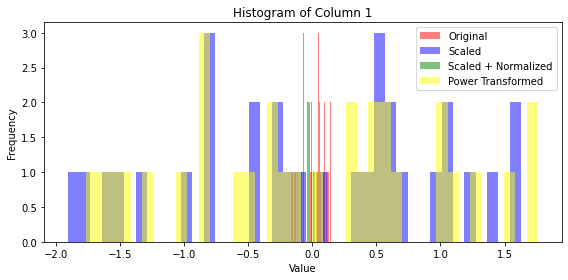

Degree


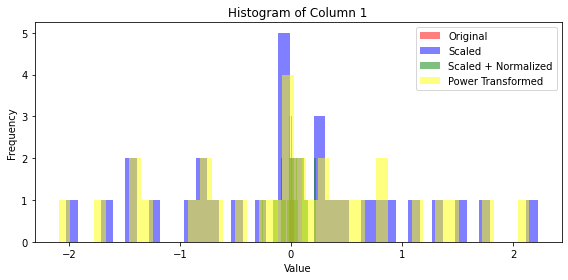

Degree_centrality


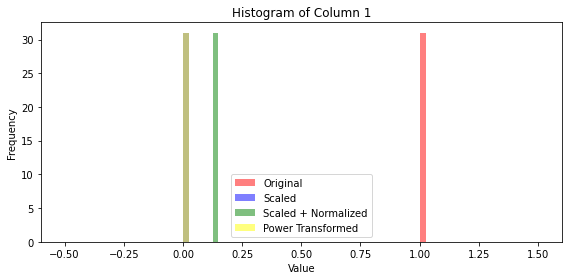

Closeness centrality


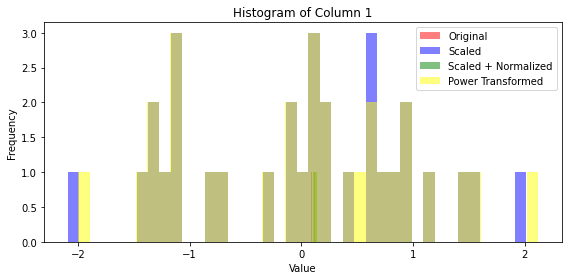

Betweenness centrality


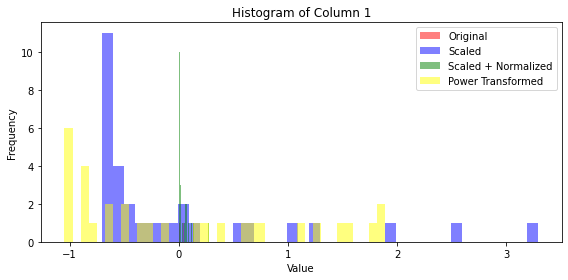

Clustering


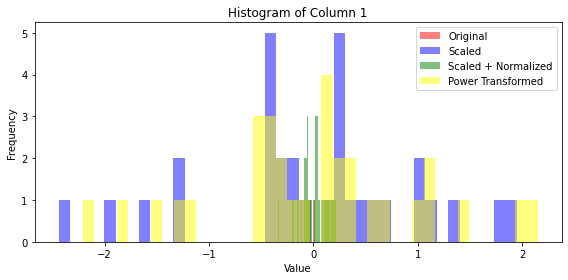

In [596]:
# Distribution of graph features

for features_matrix, g_metric in zip([X_con, X_degree,X_degreeCentrality, X_closeness, X_betweenness, X_clustering], ['Connectivity matrix', 'Degree','Degree_centrality', 'Closeness centrality', 'Betweenness centrality', 'Clustering']):
    print('================ \n{}\n================'.format(g_metric))
    
    
    feature_matrix = np.mean(feature_matrices,axis=0).reshape(-1, 1)
    # Scaling and normalization
    scaled_features_matrix = StandardScaler().fit_transform(features_matrix)
    normalized_features_matrix = normalize(features_matrix)#Pipeline([('scaler', StandardScaler()), ('norm', normalize())]).fit_transform(features_matrix)
    power_transformed_matrix = PowerTransformer().fit_transform(features_matrix)
    powerScaled_features_matrix = StandardScaler().fit_transform(power_transformed_matrix)
    # Plot settings
    num_columns = concatenated_matrices.shape[1]
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(8, 4 * num_columns))
    colors = ['red', 'blue', 'green', 'yellow']

    # Plot each column's distributions
    i=0
    ax = axes#[i]
    column_data = features_matrix[:, i]
    ax.hist(column_data, bins=40, color=colors[0], alpha=0.5, label='Original')
    ax.hist(scaled_features_matrix[:, i], bins=40, color=colors[1], alpha=0.5, label='Scaled')
    ax.hist(normalized_features_matrix[:, i], bins=40, color=colors[2], alpha=0.5, label='Scaled + Normalized')
    ax.hist(power_transformed_matrix[:, i], bins=40, color=colors[3], alpha=0.5, label='Power Transformed')

    ax.set_title(f"Histogram of Column {i + 1}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.legend()

    plt.tight_layout()
    plt.show()


Connectivity matrix
Features matrix shape: (31, 2016)
Correlation matrix shape: (2016, 2016)


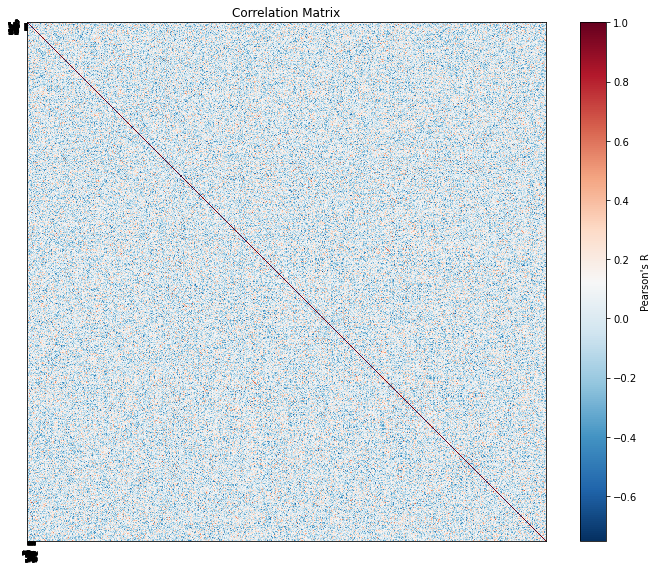

Degree
Features matrix shape: (31, 64)
Correlation matrix shape: (64, 64)


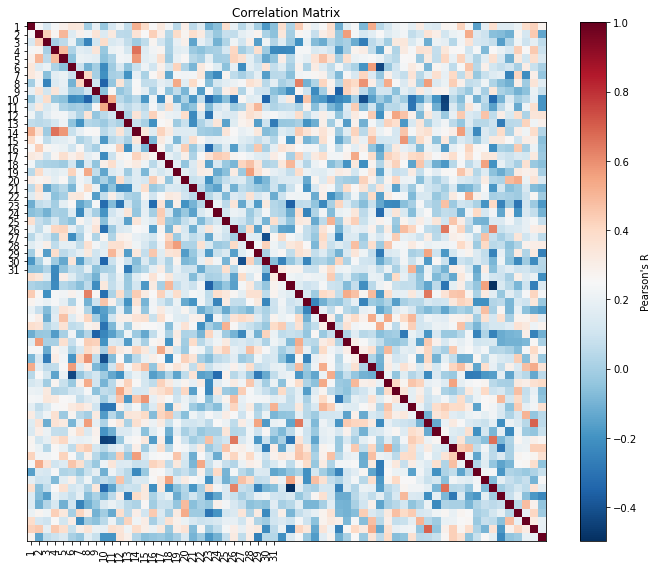

Closeness centrality
Features matrix shape: (31, 64)
Correlation matrix shape: (64, 64)


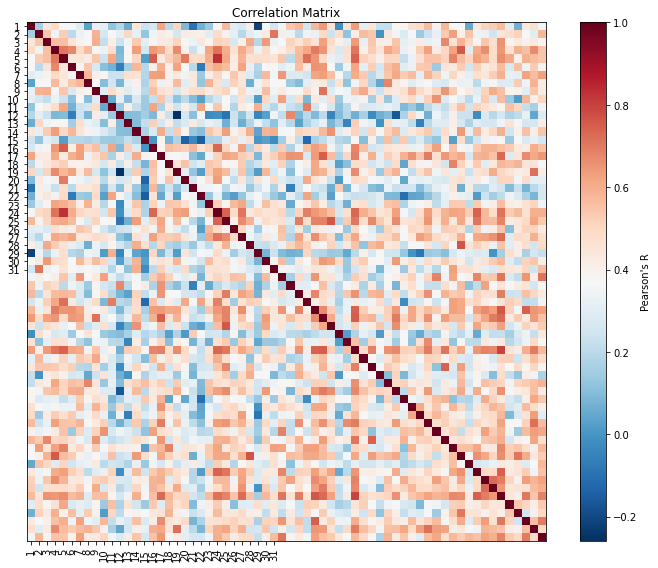

Betweenness centrality
Features matrix shape: (31, 64)
Correlation matrix shape: (64, 64)


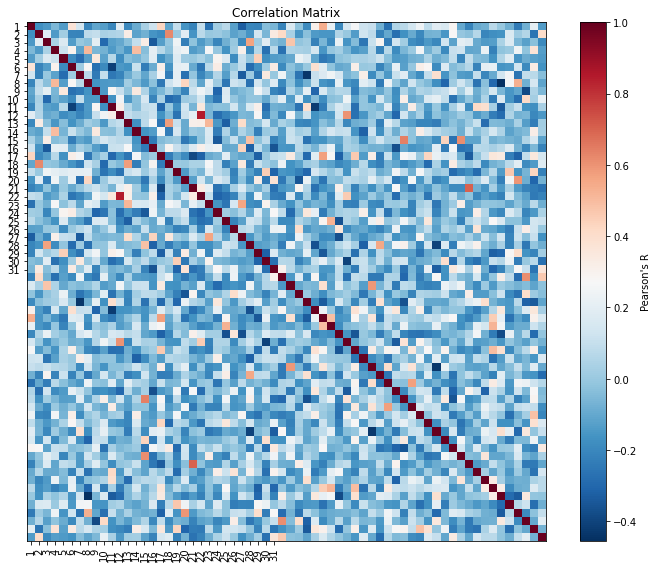

Clustering
Features matrix shape: (31, 64)
Correlation matrix shape: (64, 64)


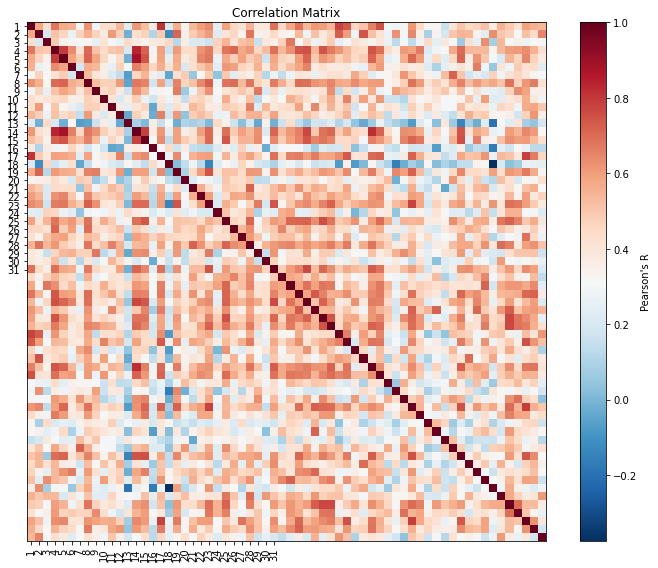

In [550]:
#checking the correlation between the features
for rawfeatures_matrix, g_metric in zip([X_con, X_degree, X_closeness, X_betweenness, X_clustering], ['Connectivity matrix', 'Degree', 'Closeness centrality', 'Betweenness centrality', 'Clustering']):
    print('================ \n{}\n================'.format(g_metric))
    print('Features matrix shape: {}'.format(rawfeatures_matrix.shape))
    correlation_matrix = np.corrcoef(rawfeatures_matrix, rowvar=False)
    print('Correlation matrix shape: {}'.format(correlation_matrix.shape))
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='RdBu_r', interpolation='nearest')
    plt.colorbar(label="Pearson's R")
    plt.title('Correlation Matrix')
    plt.xticks(range(len(features_matrix)), range(1, len(features_matrix) + 1), rotation='vertical')
    plt.yticks(range(len(features_matrix)), range(1, len(features_matrix) + 1))
    plt.tight_layout()
    plt.show()


In [ ]:
def reg_plot_performance(y_test, y_pred, y_name, mean_pearson_r, mean_rmse, mean_r2, mean_r2_pval,rmse_p_value, mean_comp, title='', path_output='', filename='regplot'):
    """
    Plot the regression plot associated with the model performance. One regression line will be plotted per fold.

    Parameters
    ----------
    y_test: list
        list containing the values of y in the test set for each fold
    y_pred: list
        list containing the values of the predicted y for each fold
    y_name: string
        name of the target variable (Y-axis label)
    mean_pearson_r: float
        mean Pearson's R value
    mean_rmse: float
        mean RMSE value
    mean_r2: float
        mean R^2 value
    mean_r2_pval: float
        mean p-value for R^2
    rmse_p_value : float
        mean p-value for RMSE
    mean_comp: float
        mean number of components
    path_output: string
        path for saving the output
    filename: string
        name of the output file

    Code adapted from https://github.com/mpcoll/coll_painvalue_2021/tree/main/figures
    """
    import matplotlib.ticker as ticker

    blue_palette_10 = sns.color_palette("Blues", 10)
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.set_xlim([min([min(y) for y in y_test]), max([max(y) for y in y_test])])
    ax1.set_ylim([min([min(y) for y in y_test]), max([max(y) for y in y_test])])
    for idx, elem in enumerate(y_test):
        df = pd.DataFrame(list(zip(elem, y_pred[idx])), columns=['Y_true', 'Y_pred'])
        sns.regplot(data=df, x='Y_true', y='Y_pred',
                    ci=None, scatter=False, color=blue_palette_10[idx],
                    ax=ax1, line_kws={'linewidth': 1.4}, truncate=False)
        ax1.xaxis.set_major_locator(ticker.AutoLocator())
        ax1.yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel(y_name)
    plt.ylabel('Cross-validated prediction')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax1.spines[axis].set_linewidth(2.6)
    ax1.tick_params(width=2.6, direction='out', length=10)
    plt.title(title)

    # Add metrics at the bottom
    metrics_text = f"Mean Pearson's R: {mean_pearson_r:.4f}\nMean RMSE: {mean_rmse:.4f} (p={rmse_p_value:.4f})\nMean R^2: {mean_r2:.4f} (p={mean_r2_pval:.4f})\nMean PCA components: {mean_comp}"
    plt.text(0.49, 0.05, metrics_text, ha='left', transform=ax1.transAxes, fontsize=  9)

    plt.show()


from sklearn.model_selection import permutation_test_score

def compute_permutation(X, y, pipeline,gr=None,cv = None, n_components=0.80, n_permutations=5000, scoring="r2", random_seed=40):
    """
    Compute the permutation test for a specified metric (r2 by default)
    Apply the PCA after the splitting procedure

    Parameters
    ----------
    X: predictive variable
    y: predicted variable
    n_components: number of components to keep for the PCA
    n_permutations: number of permuted iteration
    scoring: scoring strategy
    random_seed: controls the randomness

    Returns
    ----------
    score (float): true score
    perm_scores (ndarray): scores for each permuted samples
    pvalue (float): probability that the true score can be obtained by chance

    See also scikit-learn permutation_test_score documentation
    """
    if gr == None and cv == None:
        cv = kf = KFold(n_splits=5, random_state=random_seed, shuffle=True)
 #ShuffleSplit(n_splits = 5, test_size = 0.3, random_state = random_seed)
    elif gr != None and cv == None:     
        cv = GroupShuffleSplit(n_splits = 5, test_size = 0.3, random_state = random_seed)
    
    score, perm_scores, pvalue = permutation_test_score(estimator=pipeline, X=X, y=y, scoring=scoring, cv=cv, n_permutations=n_permutations, random_state=random_seed)
    
    return score, perm_scores, pvalue


SVR predictions 

connectivity_matrix
--- SHSS_score ---
Mean MSE: 17.388820615346553
Mean MAE: 3.437902909442795
Mean R^2: -1.6155575268548241
Mean Pearson R: -0.20902484145667022
---


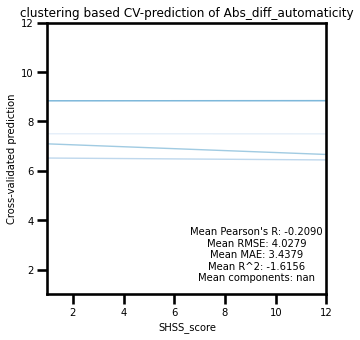

--- raw_change_ANA ---
Mean MSE: 79.12681696984389
Mean MAE: 6.851488814383012
Mean R^2: -0.17708418437905862
Mean Pearson R: 0.2946280373823425
---


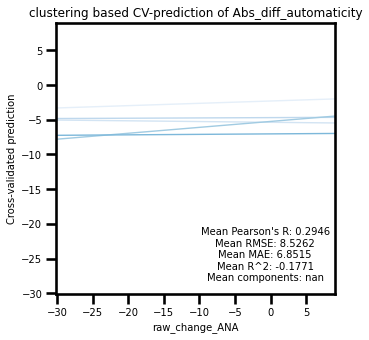

--- raw_change_HYPER ---
Mean MSE: 217.9597239813307
Mean MAE: 11.504869985783893
Mean R^2: -0.1417354967088279
Mean Pearson R: -0.10079572610424332
---


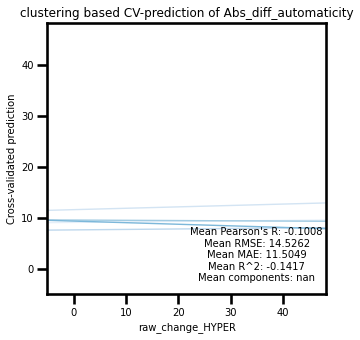

--- total_chge_pain_hypAna ---
Mean MSE: 401.39051782984416
Mean MAE: 16.902180817832747
Mean R^2: -0.07056798893761895
Mean Pearson R: -0.02293483391471727
---


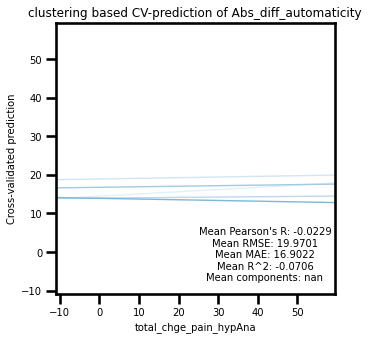

--- Chge_hypnotic_depth ---
Mean MSE: 664.8976217833659
Mean MAE: 20.384059456255493
Mean R^2: -0.07247465217851526
Mean Pearson R: -0.4134739187642552
---


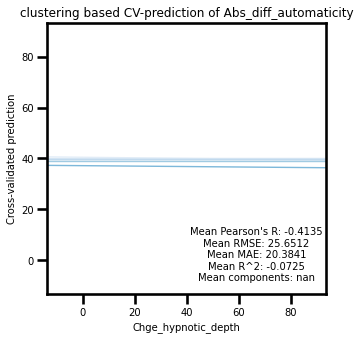

--- Mental_relax_absChange ---
Mean MSE: 456.9591967097805
Mean MAE: 16.591102195145425
Mean R^2: -0.5241709159825361
Mean Pearson R: -0.28539116407451337
---


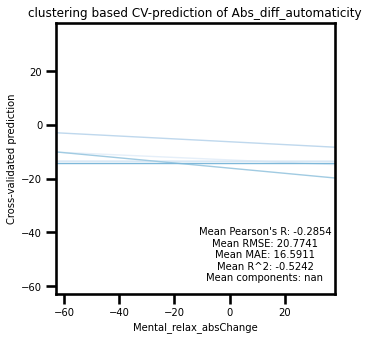

--- Abs_diff_automaticity ---
Mean MSE: 712.3643600676791
Mean MAE: 21.93942852156603
Mean R^2: -0.737442568598609
Mean Pearson R: 0.04594685673066089
---


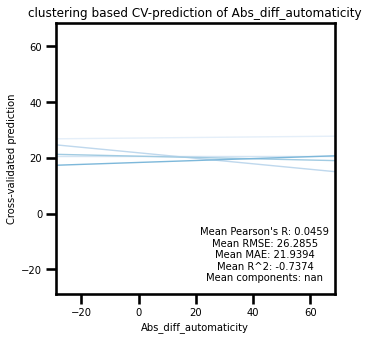

Degree
--- SHSS_score ---
Mean MSE: 16.886813670186097
Mean MAE: 3.3971204302191764
Mean R^2: -1.321460896484035
Mean Pearson R: -0.07540621621239471
---


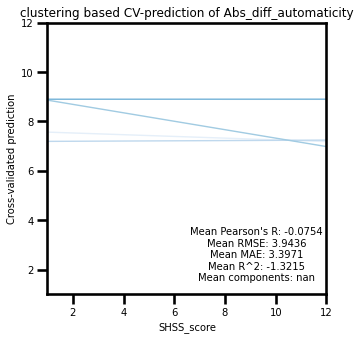

--- raw_change_ANA ---
Mean MSE: 77.53911039101982
Mean MAE: 7.040654042216903
Mean R^2: -0.16701471006859375
Mean Pearson R: 0.04655042716691253
---


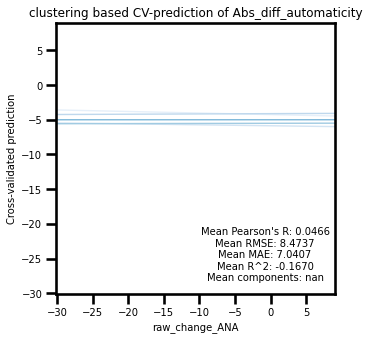

--- raw_change_HYPER ---
Mean MSE: 224.45171665677208
Mean MAE: 11.924271959473797
Mean R^2: -0.24657992793318478
Mean Pearson R: 0.030285203568272447
---


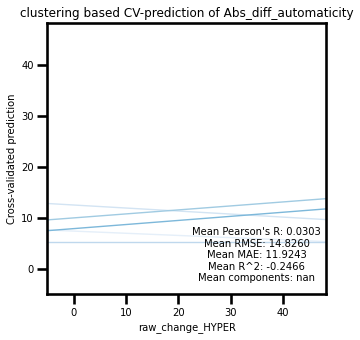

--- total_chge_pain_hypAna ---
Mean MSE: 433.8898252197997
Mean MAE: 18.02813010307364
Mean R^2: -0.16901162344059434
Mean Pearson R: 0.07145324759777645
---


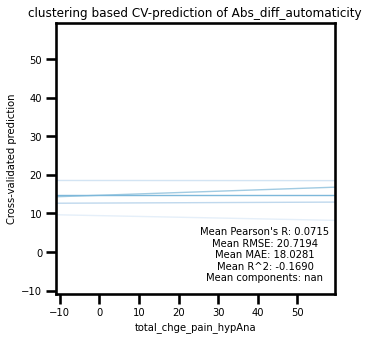

--- Chge_hypnotic_depth ---
Mean MSE: 680.2281729099285
Mean MAE: 20.244322245399445
Mean R^2: -0.09866521083256856
Mean Pearson R: 0.11749228573186876
---


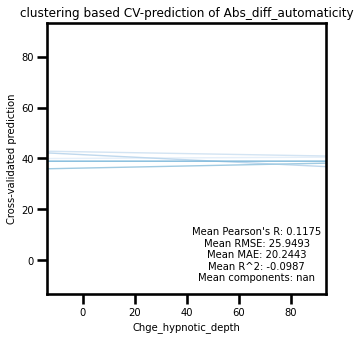

--- Mental_relax_absChange ---
Mean MSE: 399.82312558583493
Mean MAE: 15.506204907331995
Mean R^2: -0.28622530944902713
Mean Pearson R: 0.014068162368967397
---


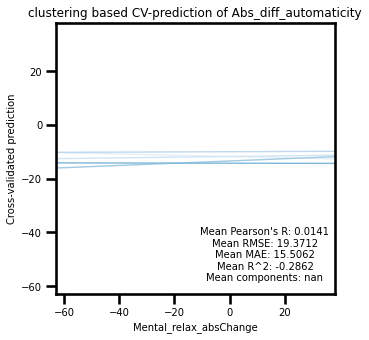

--- Abs_diff_automaticity ---
Mean MSE: 680.0874883606684
Mean MAE: 21.376756849911388
Mean R^2: -0.6470420200908503
Mean Pearson R: 0.05347429007653952
---


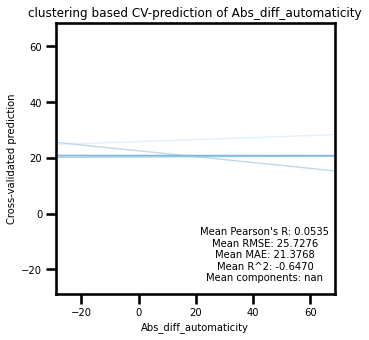

closeness
--- SHSS_score ---
Mean MSE: 16.65791910888721
Mean MAE: 3.375092285873424
Mean R^2: -1.4411355215739792
Mean Pearson R: 0.022718134297363003
---


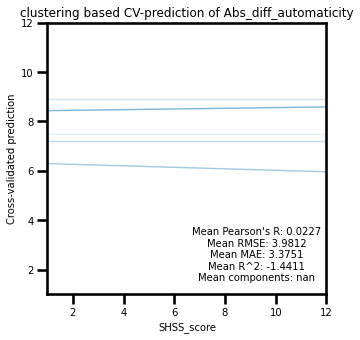

--- raw_change_ANA ---
Mean MSE: 80.82459338650057
Mean MAE: 7.070053523798087
Mean R^2: -0.18593420388388168
Mean Pearson R: -0.11323964611137663
---


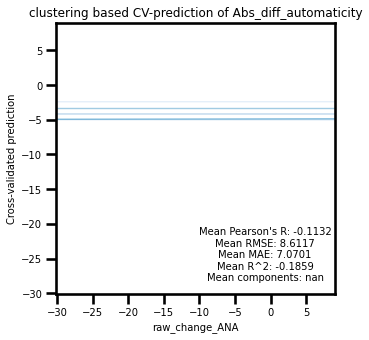

--- raw_change_HYPER ---
Mean MSE: 226.49210392482019
Mean MAE: 11.902206868089387
Mean R^2: -0.23800257275993783
Mean Pearson R: -0.0003638080878856309
---


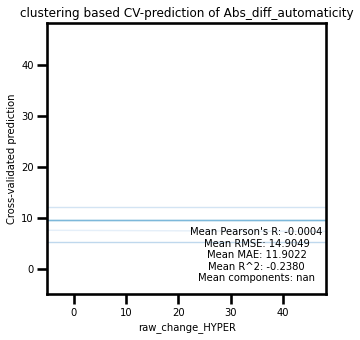

--- total_chge_pain_hypAna ---
Mean MSE: 425.04764400795386
Mean MAE: 17.561550966007538
Mean R^2: -0.1441443046154916
Mean Pearson R: 0.29454213149328423
---


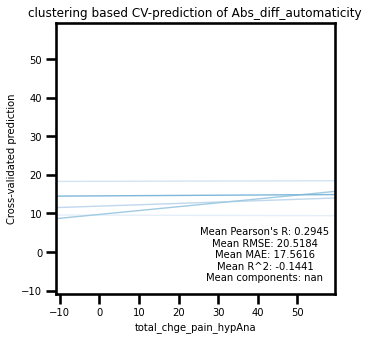

--- Chge_hypnotic_depth ---
Mean MSE: 680.9198112168485
Mean MAE: 20.475503196821112
Mean R^2: -0.09177229755994895
Mean Pearson R: 0.23310516375482687
---


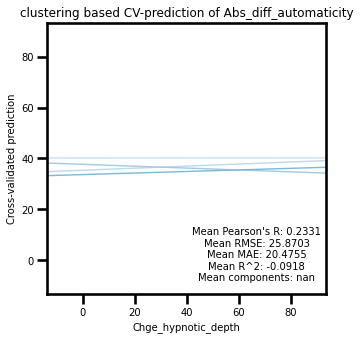

--- Mental_relax_absChange ---
Mean MSE: 403.12106607051055
Mean MAE: 15.436900001350002
Mean R^2: -0.32181638056825046
Mean Pearson R: -0.29292836293499525
---


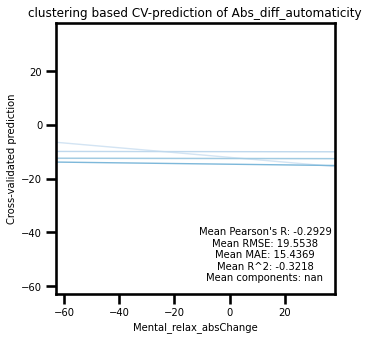

--- Abs_diff_automaticity ---
Mean MSE: 708.8007502457883
Mean MAE: 21.74519459880252
Mean R^2: -0.7124270406045315
Mean Pearson R: 0.19309144086420976
---


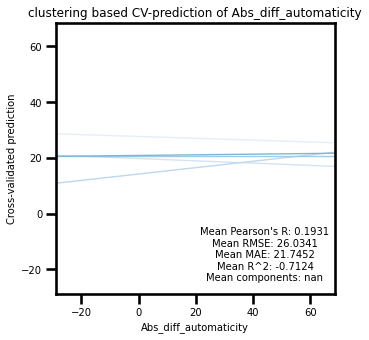

betweenness
--- SHSS_score ---
Mean MSE: 19.008544782800907
Mean MAE: 3.644718381856035
Mean R^2: -2.17613056298861
Mean Pearson R: -0.5122453081665773
---


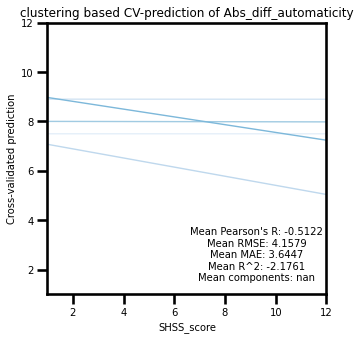

--- raw_change_ANA ---
Mean MSE: 76.85304975818417
Mean MAE: 7.2481585149915215
Mean R^2: -0.19274919863191936
Mean Pearson R: 0.3541940561332472
---


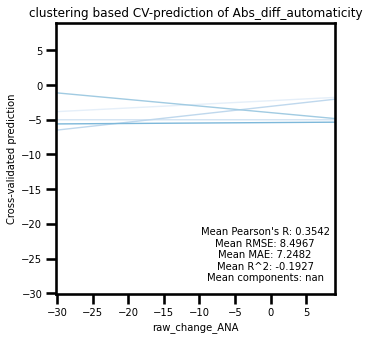

--- raw_change_HYPER ---
Mean MSE: 252.4824783187667
Mean MAE: 12.834622585196106
Mean R^2: -0.4155047283431884
Mean Pearson R: -0.3834079722617436
---


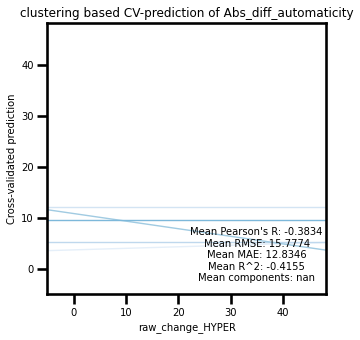

--- total_chge_pain_hypAna ---
Mean MSE: 464.50602830335276
Mean MAE: 18.79185423378672
Mean R^2: -0.26851930115948897
Mean Pearson R: -0.14440033118996648
---


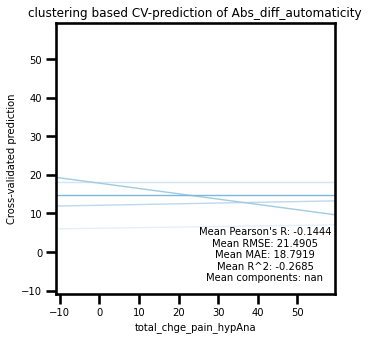

--- Chge_hypnotic_depth ---
Mean MSE: 660.0825945364403
Mean MAE: 20.266079793296278
Mean R^2: -0.06205439320190278
Mean Pearson R: 0.09654568958634846
---


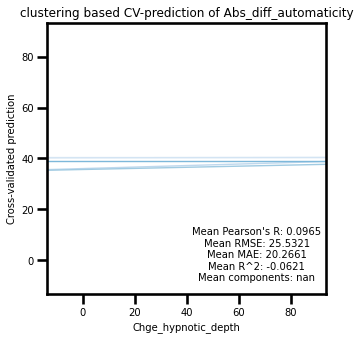

--- Mental_relax_absChange ---
Mean MSE: 409.49317551321855
Mean MAE: 15.673550608867112
Mean R^2: -0.3707131904047837
Mean Pearson R: -0.14278135945874545
---


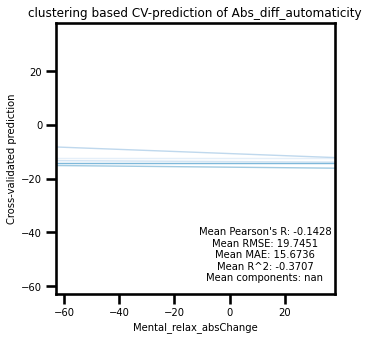

--- Abs_diff_automaticity ---
Mean MSE: 708.0912579424207
Mean MAE: 21.78920587668545
Mean R^2: -0.7324289638504075
Mean Pearson R: 0.4801568745910389
---


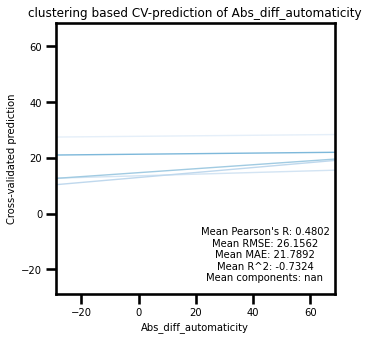

clustering
--- SHSS_score ---
Mean MSE: 15.721416673446146
Mean MAE: 3.273772362221557
Mean R^2: -1.1685744505100637
Mean Pearson R: -0.3445769219969536
---


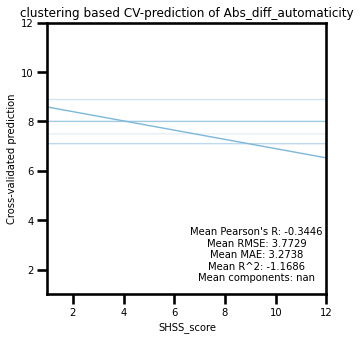

--- raw_change_ANA ---
Mean MSE: 83.82196308339867
Mean MAE: 7.177601856953489
Mean R^2: -0.37859384234199284
Mean Pearson R: -0.23107528583822826
---


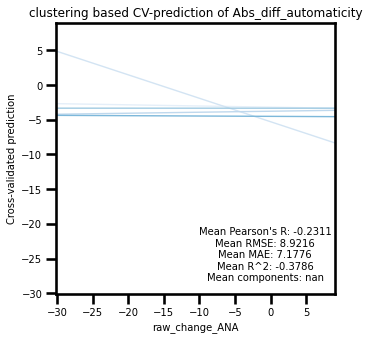

--- raw_change_HYPER ---
Mean MSE: 238.8342256526483
Mean MAE: 11.714883635463051
Mean R^2: -0.271832833773784
Mean Pearson R: -0.12195848919720413
---


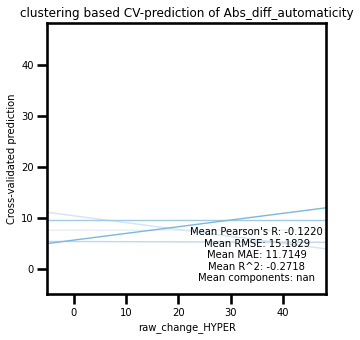

--- total_chge_pain_hypAna ---
Mean MSE: 448.29068425944024
Mean MAE: 17.65747326554692
Mean R^2: -0.1976422156578361
Mean Pearson R: -0.17787131756602678
---


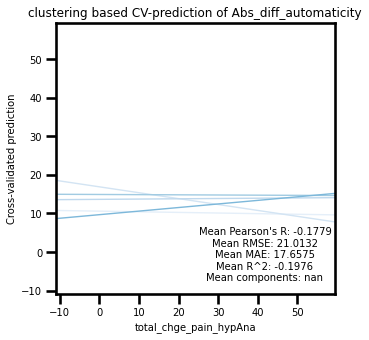

--- Chge_hypnotic_depth ---
Mean MSE: 658.4110192597611
Mean MAE: 20.160735416279273
Mean R^2: -0.06093425968500652
Mean Pearson R: -0.15392505733296527
---


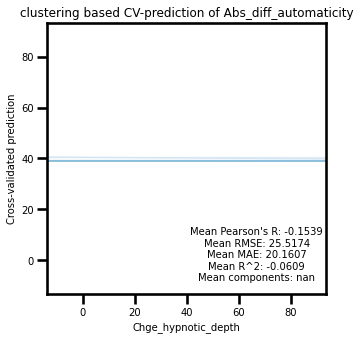

--- Mental_relax_absChange ---
Mean MSE: 400.9433274109073
Mean MAE: 15.463495119524007
Mean R^2: -0.3159601704639033
Mean Pearson R: -0.2296410707687399
---


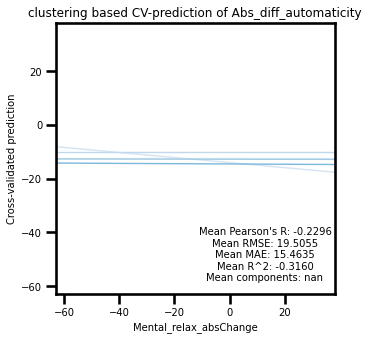

--- Abs_diff_automaticity ---
Mean MSE: 697.7014274912035
Mean MAE: 21.233246703656732
Mean R^2: -0.692450356970961
Mean Pearson R: 0.11088854586092796
---


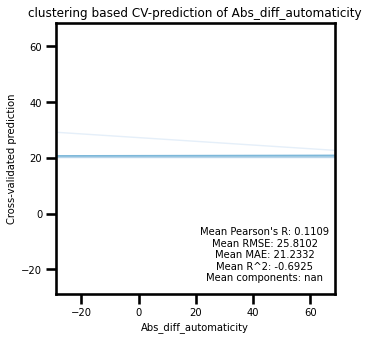

In [344]:
#SVR model for each graph metric
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.stats import pearsonr
import numpy as np

ist to store mean metrics
mean_metrics = []

for features_matrix, g_metric in zip([X_con, X_degree, X_closeness,X_betweenness, X_clustering], ['connectivity_matrix', 'Degree', 'closeness','betweenness', 'clustering']):
    print('================ \n{}\n================'.format(g_metric))
    
    for target_column in target_columns:
        print(f"--- {target_column} ---")
        
        y_preds = []
        y_tests = []
        y = Y[target_column].values
        
        # Define the hyperparameter grid
        param_grid = {
            'kernel': ('linear', 'rbf'),
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.2, 0.3],
        }
        
        # Create a pipeline with StandardScaler, PCA, and SVR
        pipeline = Pipeline([
            ('std', StandardScaler()),
            ('pca', PCA(n_components=0.80)),
            ('svr', SVR())
        ])
        std_scaler = StandardScaler()
        pca = PCA(n_components=0.80)
        svr = SVR()

        # Cross-validation
        k = 5  # Number of folds
        kf = KFold(n_splits=k, random_state=4, shuffle=True)
        
        pearson_r_scores = []
        r2_scores = []
        mae_scores = []
        mse_scores = []
        rmse_scores = []

        for train_index, test_index in kf.split(features_matrix):
            X_train, X_test = features_matrix[train_index], features_matrix[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Apply StandardScaler and PCA to X_train
            X_train_scaled = std_scaler.fit_transform(X_train)
            X_train_pca = pca.fit_transform(X_train_scaled)

            grid_search = GridSearchCV(svr, param_grid, cv=kf)
            grid_search.fit(X_train, y_train)

            y_pred = grid_search.predict(X_test)
            y_preds.append(y_pred)
            y_tests.append(y_test)

            # Calculate evaluation metrics
            pearson_r, _ = pearsonr(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)

            # Append metrics to the respective lists
            pearson_r_scores.append(pearson_r)
            r2_scores.append(r2)
            mae_scores.append(mae)
            mse_scores.append(mse)
            rmse_scores.append(rmse)
        
        # Calculate mean metrics across all folds
        mean_pearson_r = np.mean(pearson_r_scores)
        mean_r2 = np.mean(r2_scores)
        mean_mae = np.mean(mae_scores)
        mean_mse = np.mean(mse_scores)
        mean_rmse = np.mean(rmse_scores)
        
        # Print the mean performance metrics
        print("Mean MSE:", mean_mse)
        print("Mean MAE:", mean_mae)
        print("Mean R^2:", mean_r2)
        print("Mean Pearson R:", mean_pearson_r)
        print("---")
        
        # Append mean metrics to the list
        mean_metrics.append((mean_mse, mean_mae, mean_r2, mean_pearson_r))

        reg_plot_performance(y_tests, y_preds, target_column, mean_pearson_r, mean_rmse, mean_mae, mean_r2, mean_n_components, title = plot_title)


Ridge model

In [554]:
# Imports 
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA, SparsePCA, FastICA
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.linear_model import RidgeCV
from statsmodels.stats.multitest import fdrcorrection


Connectivity matrix
--- SHSS_score ---
Permutation test for r2 values: p=0.2791


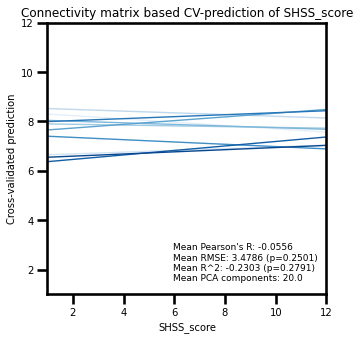

--- raw_change_ANA ---
Permutation test for r2 values: p=0.5371


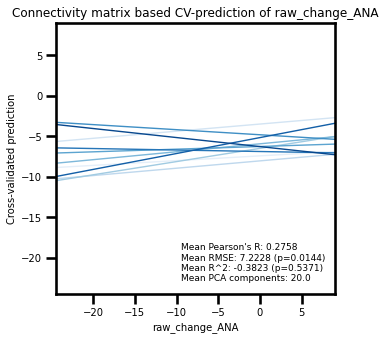

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.2943


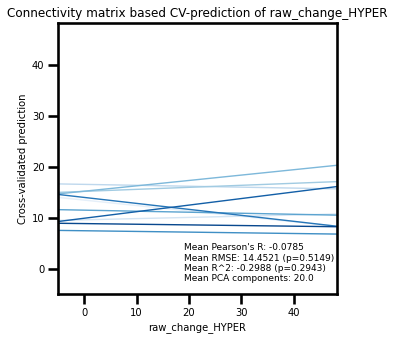

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.3087


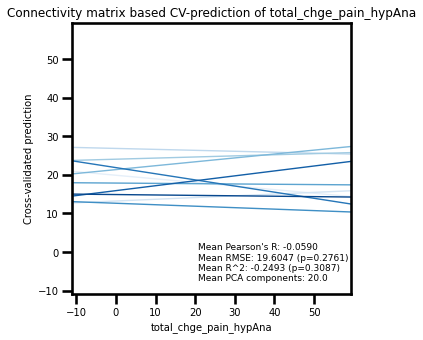

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.8334


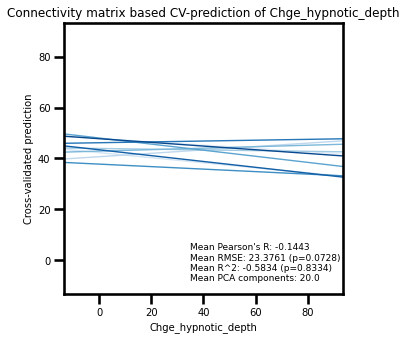

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.5229


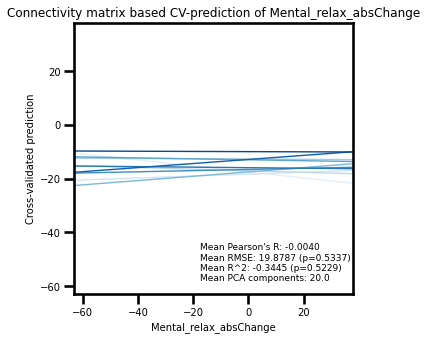

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.1336


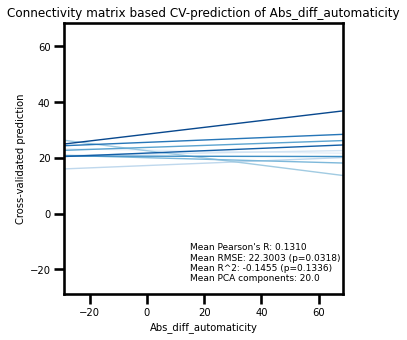

Degree
--- SHSS_score ---
Permutation test for r2 values: p=0.7285


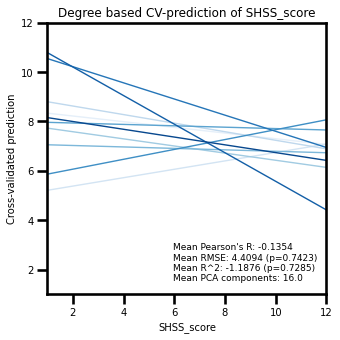

--- raw_change_ANA ---
Permutation test for r2 values: p=0.5853


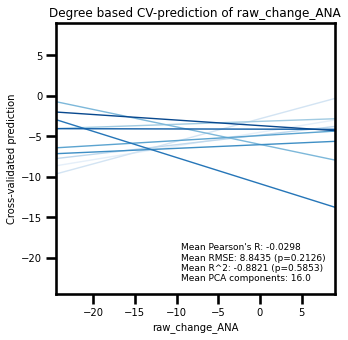

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.0004


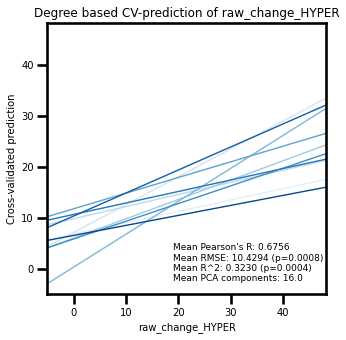

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.0016


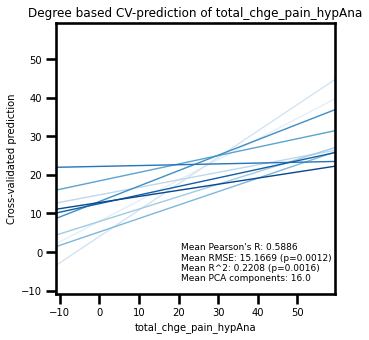

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.4695


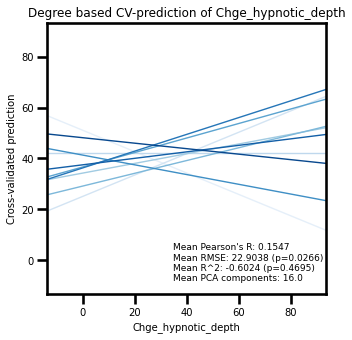

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.5199


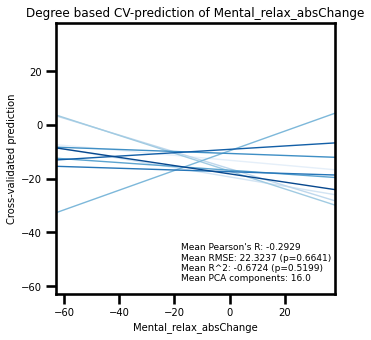

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.5563


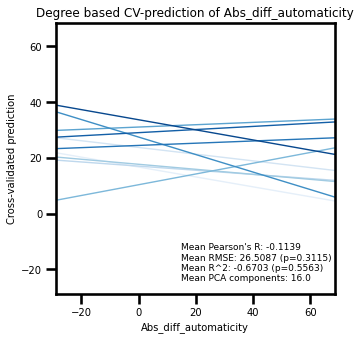

Closeness centrality
--- SHSS_score ---
Permutation test for r2 values: p=0.7117


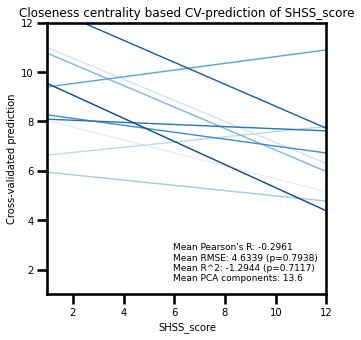

--- raw_change_ANA ---
Permutation test for r2 values: p=0.9296


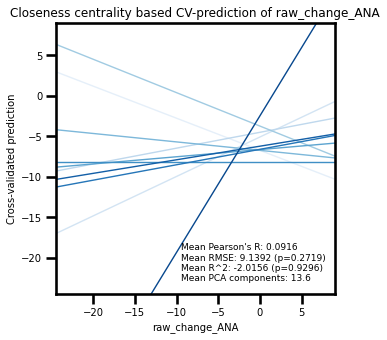

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.1446


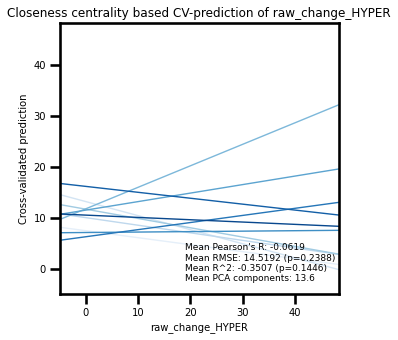

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.1106


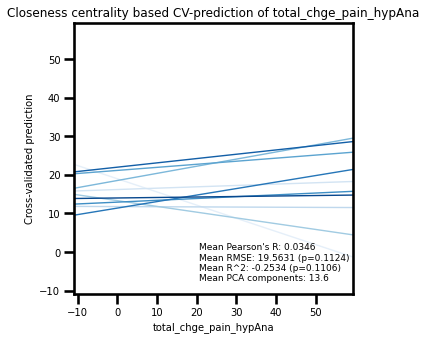

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.8718


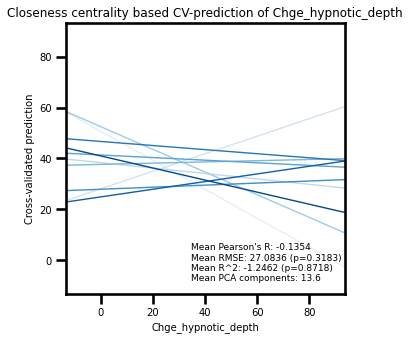

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.9052


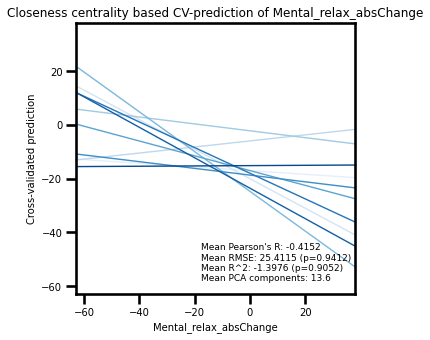

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.3545


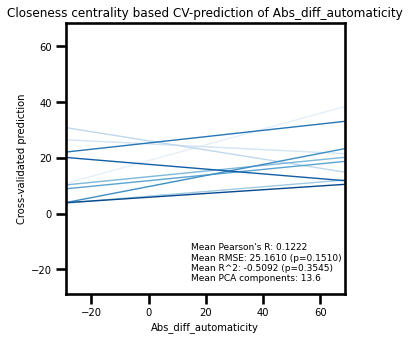

Betweenness centrality
--- SHSS_score ---
Permutation test for r2 values: p=0.7878


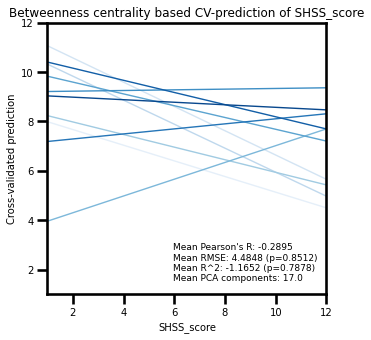

--- raw_change_ANA ---
Permutation test for r2 values: p=0.9002


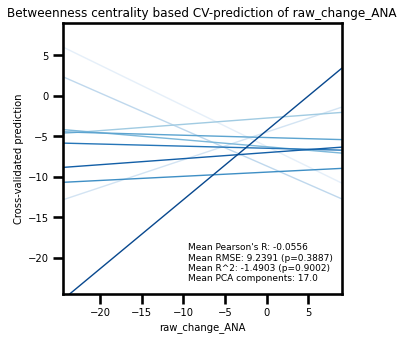

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.4711


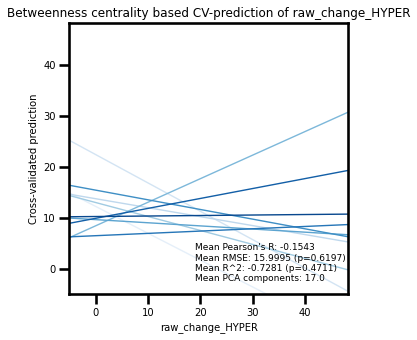

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.6331


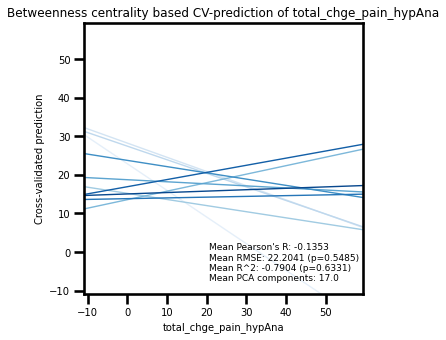

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.9394


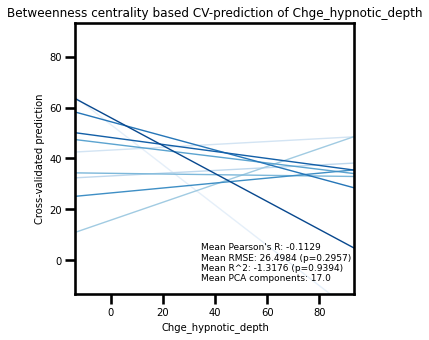

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.5281


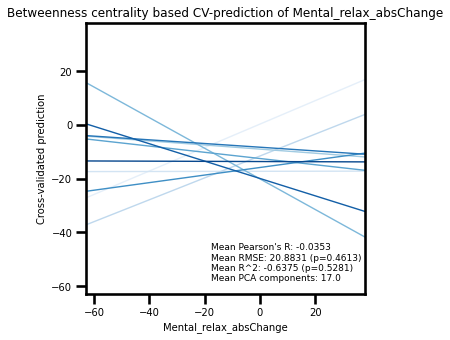

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.6191


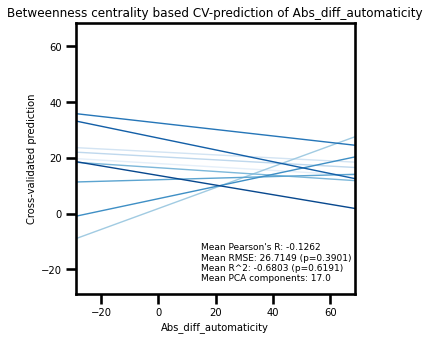

Clustering
--- SHSS_score ---
Permutation test for r2 values: p=0.6247


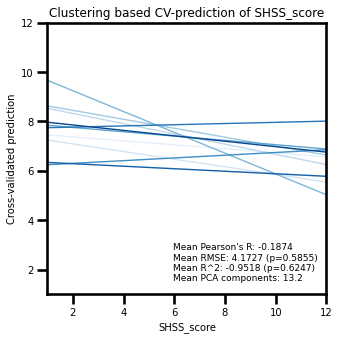

--- raw_change_ANA ---
Permutation test for r2 values: p=0.6227


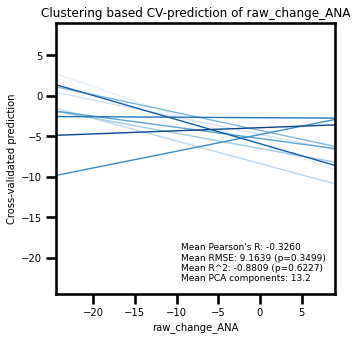

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.4201


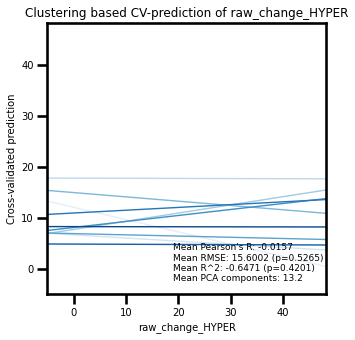

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.4699


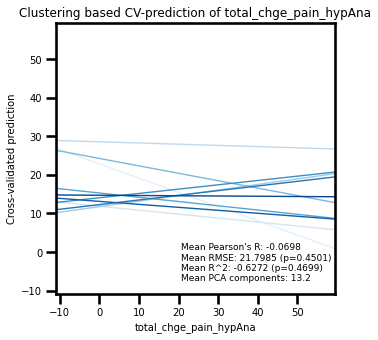

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.1228


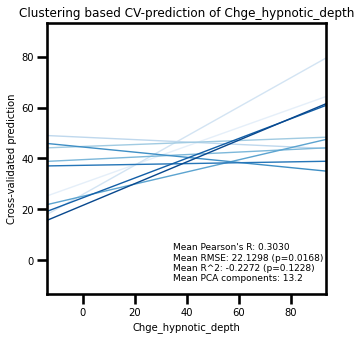

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.2066


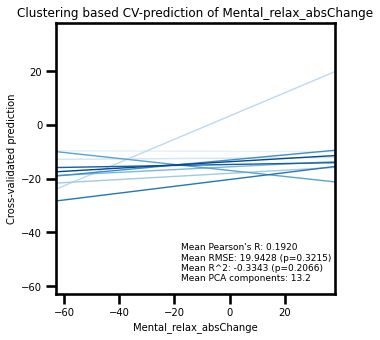

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.2310


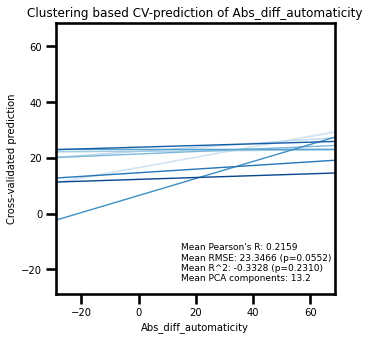

In [673]:
# Ridge model and output for each graph metric and dependent variable
#feature_matrices = [X_degree, X_degreeCentrality, X_closeness, X_betweenness, X_clustering]
#concatenated_matrices = np.vstack(feature_matrices)
#num_participants = X_degree.shape[0]
#group_column = np.tile(np.arange(1, num_participants + 1), len(feature_matrices))

random_seed = 0
for rawfeatures_matrix, g_metric in zip([X_con, X_degree, X_closeness, X_betweenness, X_clustering], ['Connectivity matrix', 'Degree', 'Closeness centrality', 'Betweenness centrality', 'Clustering']):
    print('================ \n{}\n================'.format(g_metric))
    
    prePipeline = Pipeline([('scaler', StandardScaler())])
    features_matrix = prePipeline.fit_transform(rawfeatures_matrix)

    #pipeline = Pipeline([('std', QuantileTransformer(n_quantiles=22)), ('pca', PCA(n_components=0.80)), ('ridge', Ridge())])
    pipeline = Pipeline([('pca', PCA(n_components=0.90)), ('reg', SVR(kernel='linear'))])
    #cv = KFold(n_splits=5, random_state=random_seed, shuffle=True)
    cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=random_seed)

    for target_column in target_columns:
        print(f"--- {target_column} ---")
        y_preds = []
        y_tests = []
        y = Y[target_column].values
        # Add covariates to the feature matrix (?!!)
        add_cov = False
        #if  target_column != 'SHSS_score':
            #add_cov = True
            #covariate_column = 'SHSS_score'
        '''
        if target_column != 'SHSS_score':
            covariate_column = 'Abs_diff_automaticity'
            add_cov = True
        if add_cov:    
            features_matrix = np.hstack((features_matrix, Y[covariate_column].values.reshape(-1, 1)))
            covariate_corr, p_value = pearsonr(Y[covariate_column], y)
            p_value_corrected = fdrcorrection([p_value])[1][0]  # Apply FDR correction
            print(f"Pearson correlation between {covariate_column} and {target_column}:\n r={covariate_corr:.4f} (FDR corrected p-value: p={p_value_corrected:.4f})")
        '''
        
        pearson_r_scores = []
        r2_scores = []
        mse_scores = []
        rmse_scores = []
        n_components = []
        all_coefficients = []
        
        for train_index, test_index in cv.split(features_matrix):
            # Split the data into train and test sets based on the current fold
            X_train, X_test = features_matrix[train_index], features_matrix[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # Fit pipeline model with best hyperparameters
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_preds.append(y_pred)
            y_tests.append(y_test)

            # Calculate evaluation metrics
            pearson_r, _ = pearsonr(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)

            # Append metrics to the respective lists
            pearson_r_scores.append(pearson_r)
            r2_scores.append(r2)
            mse_scores.append(mse)
            rmse_scores.append(rmse)
            n_components.append(pipeline.named_steps['pca'].n_components_)
            coefficients = pipeline.named_steps['reg'].coef_
            all_coefficients.append(coefficients)

        #Permutation tests
        r2score, _, r2p_value = compute_permutation(features_matrix, y, pipeline, cv = cv, scoring='r2', random_seed=random_seed)
        rmse_score, _, rmse_p_value = compute_permutation(features_matrix, y, pipeline, cv = cv, scoring='neg_root_mean_squared_error', random_seed=random_seed)
        #r2p_value,rmse_p_value = 0.00001, 0.00001
        
        print(f"Permutation test for r2 values: p={r2p_value:.4f}")
        # Calculate mean metrics across all folds
        mean_pearson_r = np.mean(pearson_r_scores)
        mean_r2 = np.mean(r2_scores)
        mean_mse = np.mean(mse_scores)
        mean_rmse = np.mean(rmse_scores)
        mean_n_components = np.mean(n_components)
        # Calculate standard deviation metrics across all folds
        # avg_z_score = np.mean(np.array(all_coefficients), axis=0) / np.std(all_coefficients, axis=0)
        # print(f"Average z-score = {avg_z_score} std = {np.std(all_coefficients, axis=0)}")
        # Plot
        plot_title = f"{g_metric} based CV-prediction of {target_column}"
        reg_plot_performance(y_tests, y_preds, target_column, mean_pearson_r, mean_rmse, mean_r2, r2p_value,rmse_p_value, mean_n_components, title=plot_title)


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (31). n_quantiles is set to n_samples.
  warnings.warn(


0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


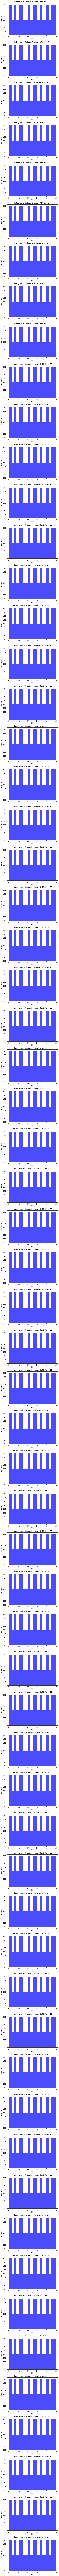

In [511]:
import matplotlib.pyplot as plt

features_matrix = QuantileTransformer(n_quantiles=32).fit_transform(X_degree)

# Assuming 'features_matrix' is your feature matrix
num_columns = features_matrix.shape[1]  # Get the number of columns in the matrix

# Create subplots for each column
fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(6, 4 * num_columns))

# Loop through each column and plot a histogram
for i in range(num_columns):
    ax = axes[i]
    print(min(features_matrix[:, i]), max(features_matrix[:, i]))
    column_data = features_matrix[:, i]  # Get the data of the current column
    ax.hist(column_data, bins=20, color='blue', alpha=0.7)  # Plot histogram
    ax.set_title(f"Histogram of Column {i + 1} mean={np.mean(column_data):.2f} std={np.std(column_data):.2f}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


Connectivity matrix
--- SHSS_score ---
Permutation test for r2 values: p=0.8628


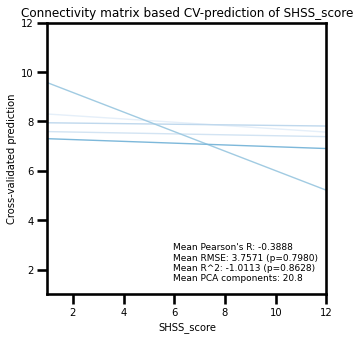

--- raw_change_ANA ---
Permutation test for r2 values: p=0.0864


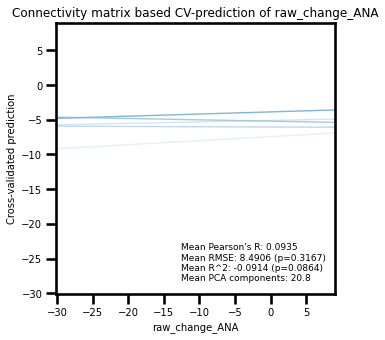

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.1522


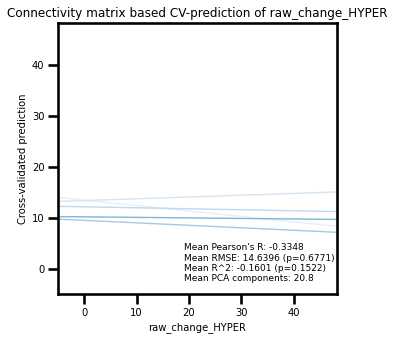

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.2567


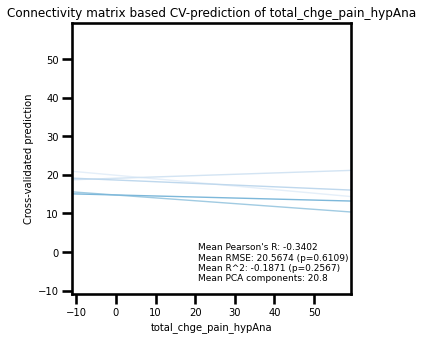

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.9420


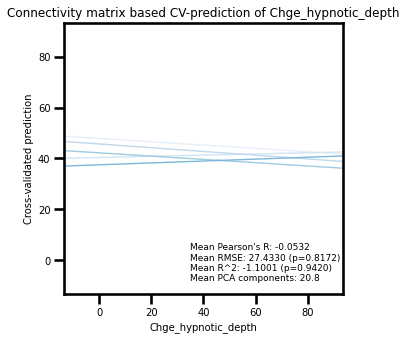

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.1298


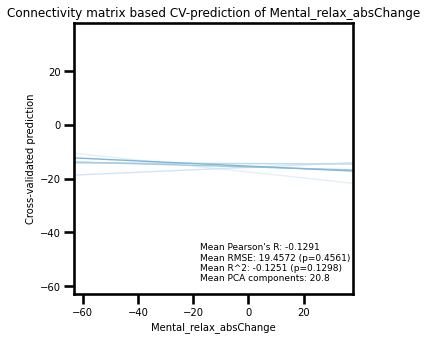

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.4569


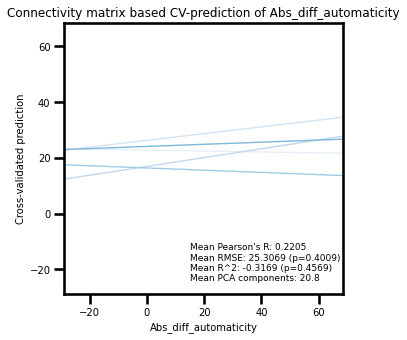

Degree
--- SHSS_score ---
Permutation test for r2 values: p=0.6617


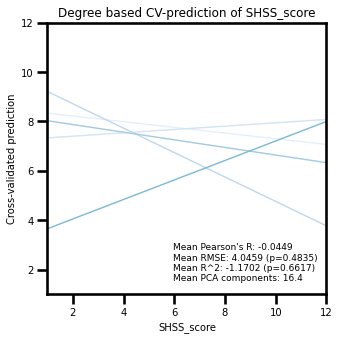

--- raw_change_ANA ---
Permutation test for r2 values: p=0.4421


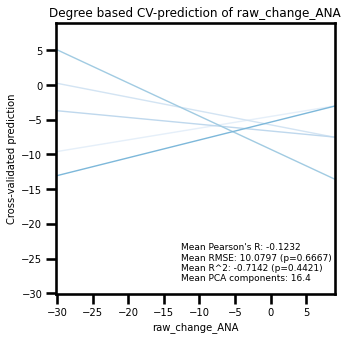

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.0016


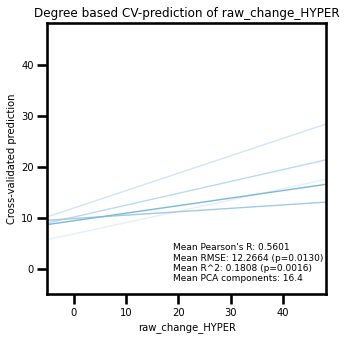

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.0116


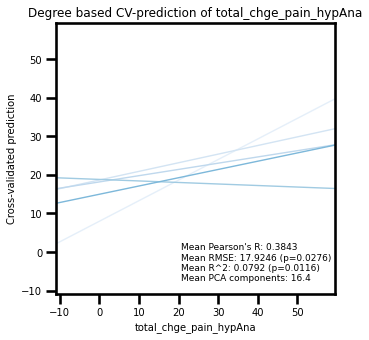

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.7674


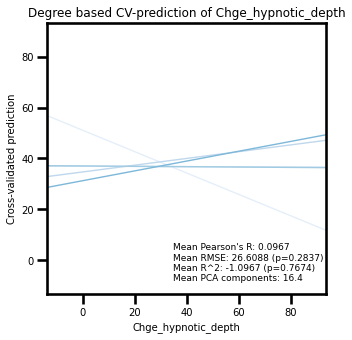

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.2366


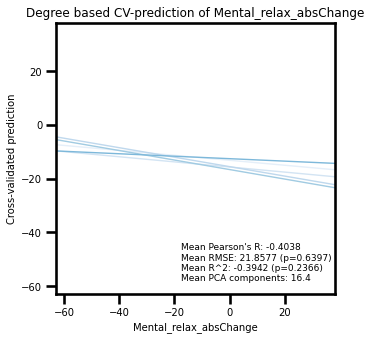

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.3945


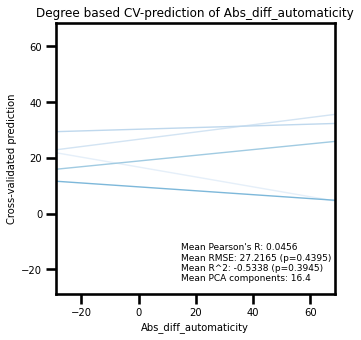

Closeness centrality
--- SHSS_score ---
Permutation test for r2 values: p=0.4669


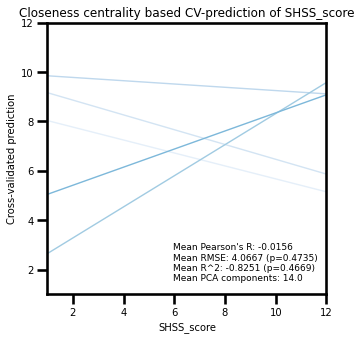

--- raw_change_ANA ---
Permutation test for r2 values: p=0.2529


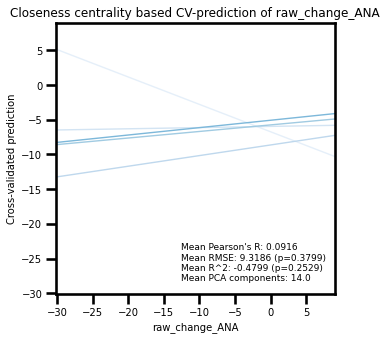

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.1060


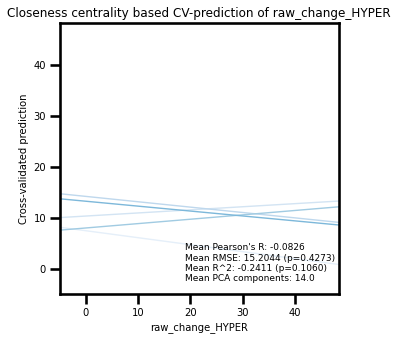

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.1492


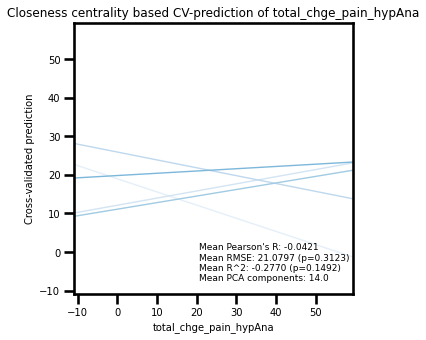

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.8982


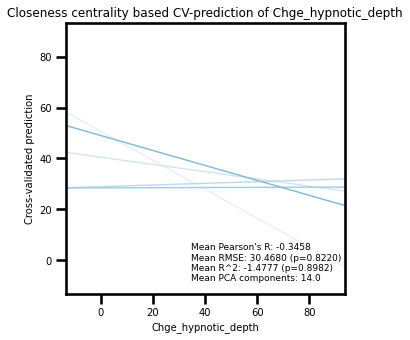

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.6413


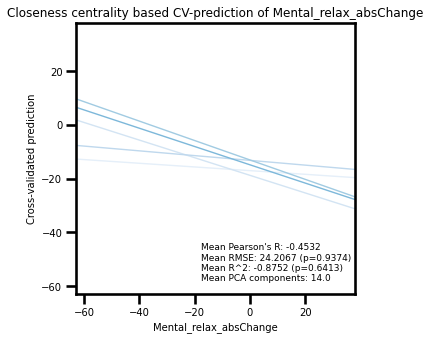

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.3271


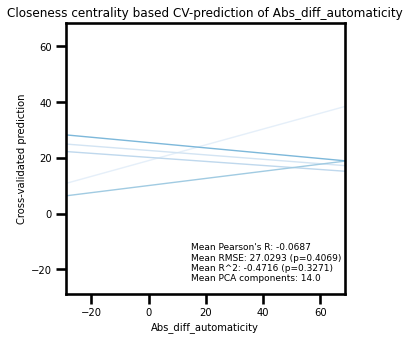

Betweenness centrality
--- SHSS_score ---
Permutation test for r2 values: p=0.8478


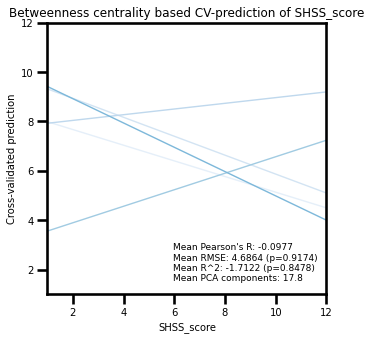

--- raw_change_ANA ---
Permutation test for r2 values: p=0.3723


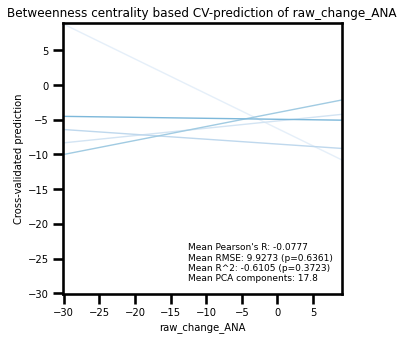

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.5079


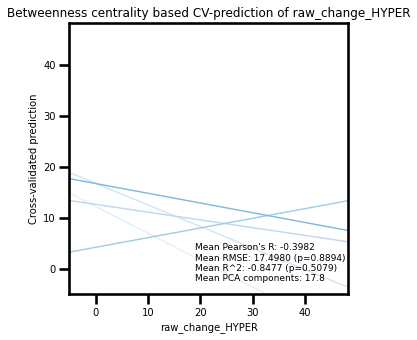

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.6347


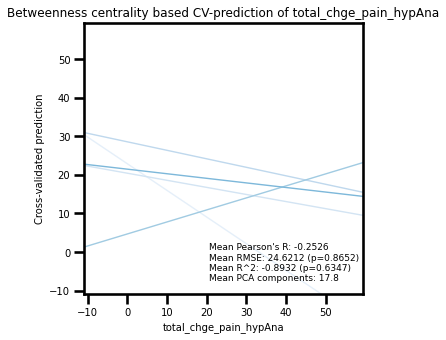

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.9622


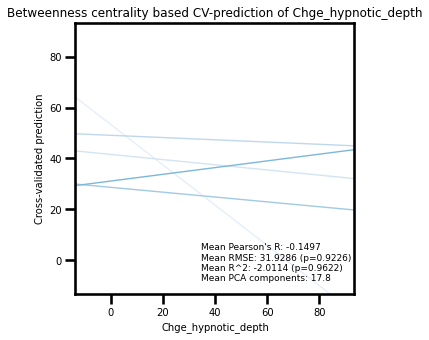

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.0524


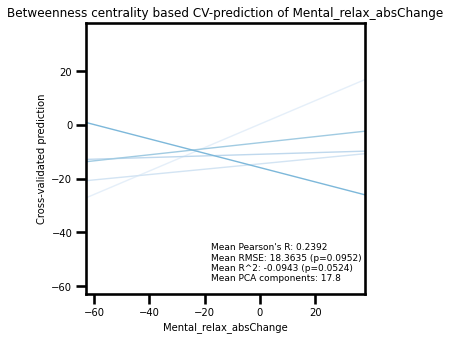

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.6345


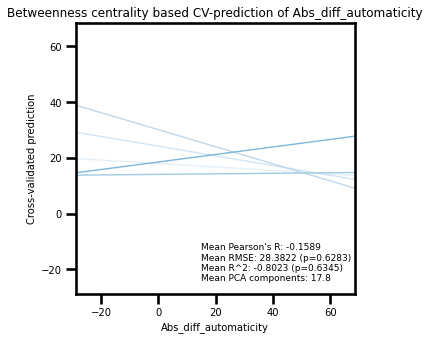

Clustering
--- SHSS_score ---
Permutation test for r2 values: p=0.8846


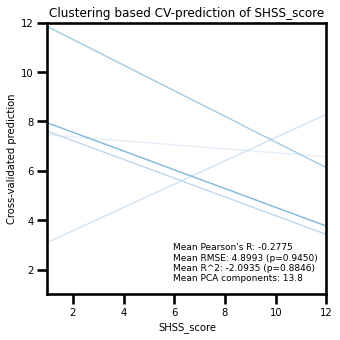

--- raw_change_ANA ---
Permutation test for r2 values: p=0.2543


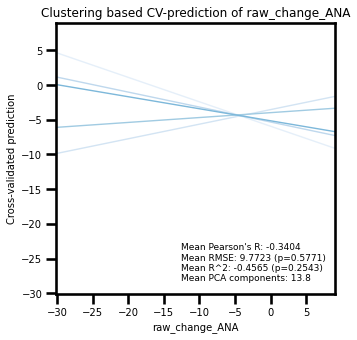

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.1508


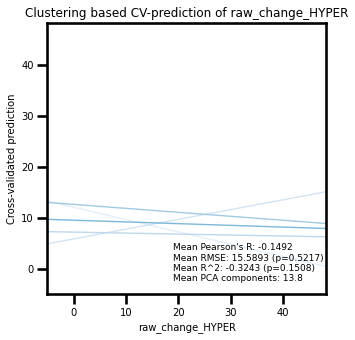

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.2825


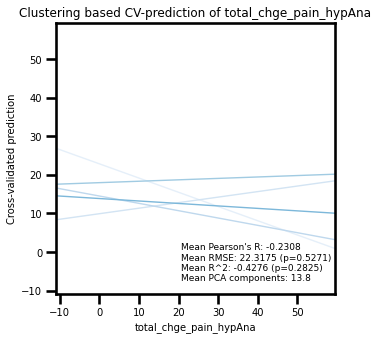

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.8024


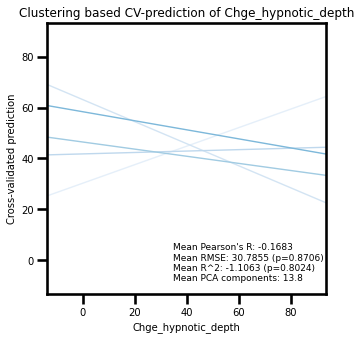

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.0464


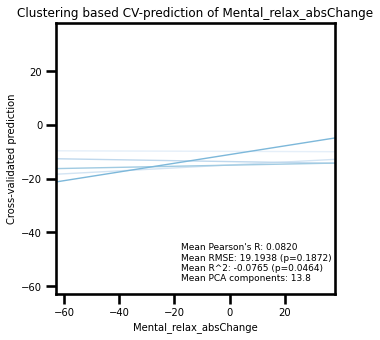

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.5743


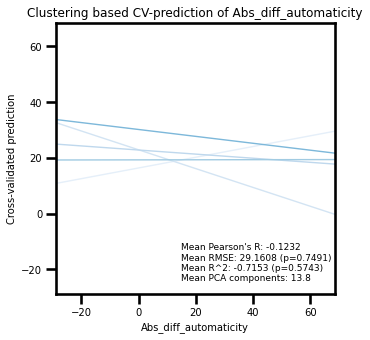

In [674]:
# Ridge model and output for each graph metric and dependent variable
#feature_matrices = [X_degree, X_degreeCentrality, X_closeness, X_betweenness, X_clustering]
#concatenated_matrices = np.vstack(feature_matrices)
#num_participants = X_degree.shape[0]
#group_column = np.tile(np.arange(1, num_participants + 1), len(feature_matrices))

random_seed = 0
for rawfeatures_matrix, g_metric in zip([X_con, X_degree, X_closeness, X_betweenness, X_clustering], ['Connectivity matrix', 'Degree', 'Closeness centrality', 'Betweenness centrality', 'Clustering']):
    print('================ \n{}\n================'.format(g_metric))
    
    prePipeline = Pipeline([('scaler', StandardScaler())])
    features_matrix = prePipeline.fit_transform(rawfeatures_matrix)

    #pipeline = Pipeline([('std', QuantileTransformer(n_quantiles=22)), ('pca', PCA(n_components=0.80)), ('ridge', Ridge())])
    pipeline = Pipeline([('pca', PCA(n_components=0.90)), ('reg', SVR(kernel='linear'))])
    cv = KFold(n_splits=5, random_state=random_seed, shuffle=True)
    #cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=random_seed)

    for target_column in target_columns:
        print(f"--- {target_column} ---")
        y_preds = []
        y_tests = []
        y = Y[target_column].values
        # Add covariates to the feature matrix (?!!)
        add_cov = False
        #if  target_column != 'SHSS_score':
            #add_cov = True
            #covariate_column = 'SHSS_score'
        '''
        if target_column != 'SHSS_score':
            covariate_column = 'Abs_diff_automaticity'
            add_cov = True
        if add_cov:    
            features_matrix = np.hstack((features_matrix, Y[covariate_column].values.reshape(-1, 1)))
            covariate_corr, p_value = pearsonr(Y[covariate_column], y)
            p_value_corrected = fdrcorrection([p_value])[1][0]  # Apply FDR correction
            print(f"Pearson correlation between {covariate_column} and {target_column}:\n r={covariate_corr:.4f} (FDR corrected p-value: p={p_value_corrected:.4f})")
        '''
        
        pearson_r_scores = []
        r2_scores = []
        mse_scores = []
        rmse_scores = []
        n_components = []
        all_coefficients = []
        
        for train_index, test_index in cv.split(features_matrix):
            # Split the data into train and test sets based on the current fold
            X_train, X_test = features_matrix[train_index], features_matrix[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # Fit pipeline model with best hyperparameters
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_preds.append(y_pred)
            y_tests.append(y_test)

            # Calculate evaluation metrics
            pearson_r, _ = pearsonr(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)

            # Append metrics to the respective lists
            pearson_r_scores.append(pearson_r)
            r2_scores.append(r2)
            mse_scores.append(mse)
            rmse_scores.append(rmse)
            n_components.append(pipeline.named_steps['pca'].n_components_)
            coefficients = pipeline.named_steps['reg'].coef_
            all_coefficients.append(coefficients)

        #Permutation tests
        r2score, _, r2p_value = compute_permutation(features_matrix, y, pipeline, cv = cv, scoring='r2', random_seed=random_seed)
        rmse_score, _, rmse_p_value = compute_permutation(features_matrix, y, pipeline, cv = cv, scoring='neg_root_mean_squared_error', random_seed=random_seed)
        #r2p_value,rmse_p_value = 0.00001, 0.00001
        
        print(f"Permutation test for r2 values: p={r2p_value:.4f}")
        # Calculate mean metrics across all folds
        mean_pearson_r = np.mean(pearson_r_scores)
        mean_r2 = np.mean(r2_scores)
        mean_mse = np.mean(mse_scores)
        mean_rmse = np.mean(rmse_scores)
        mean_n_components = np.mean(n_components)
        # Calculate standard deviation metrics across all folds
        # avg_z_score = np.mean(np.array(all_coefficients), axis=0) / np.std(all_coefficients, axis=0)
        # print(f"Average z-score = {avg_z_score} std = {np.std(all_coefficients, axis=0)}")
        # Plot
        plot_title = f"{g_metric} based CV-prediction of {target_column}"
        reg_plot_performance(y_tests, y_preds, target_column, mean_pearson_r, mean_rmse, mean_r2, r2p_value,rmse_p_value, mean_n_components, title=plot_title)


Connectivity matrix
--- SHSS_score ---
Permutation test for r2 values: p=0.3653


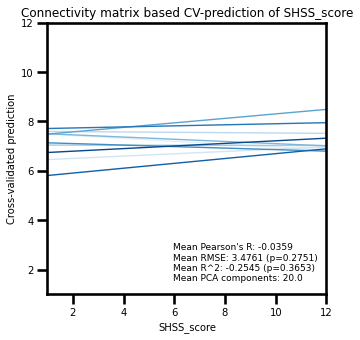

--- raw_change_ANA ---
Permutation test for r2 values: p=0.1594


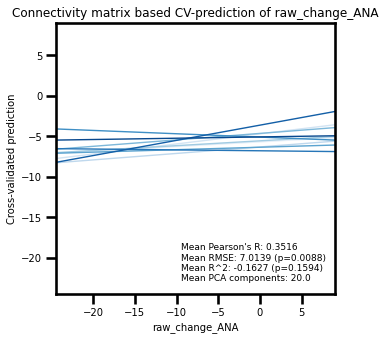

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.2200


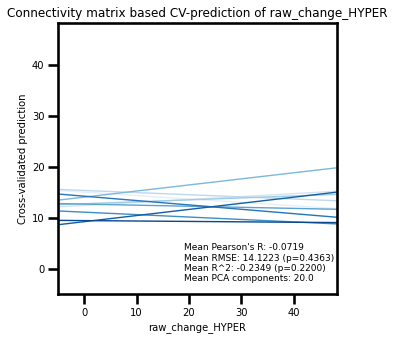

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.1118


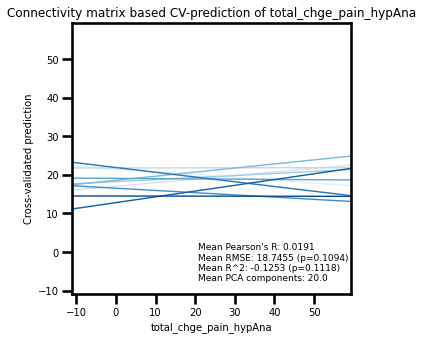

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.8198


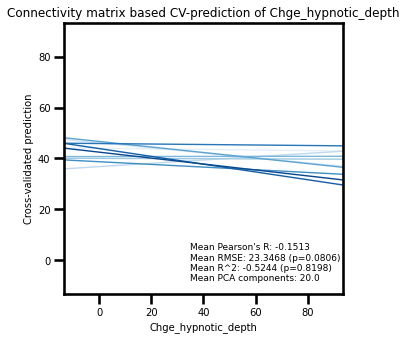

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.3485


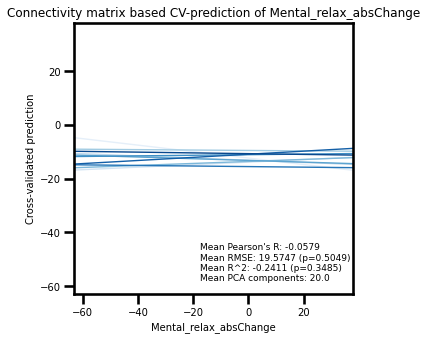

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.0612


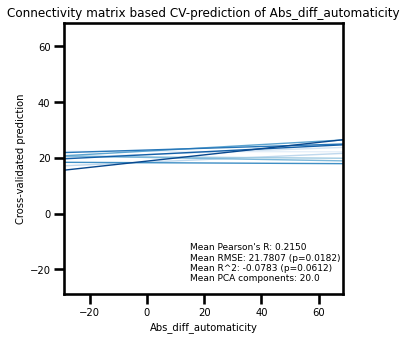

Degree
--- SHSS_score ---
Permutation test for r2 values: p=0.5539


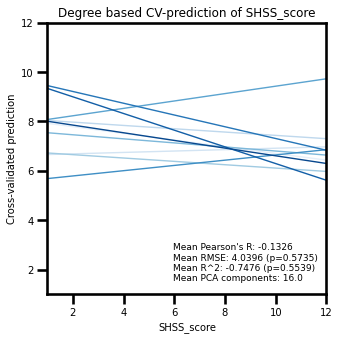

--- raw_change_ANA ---
Permutation test for r2 values: p=0.6915


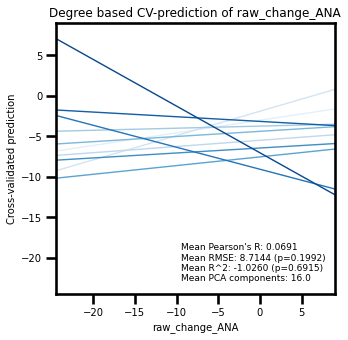

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.0006


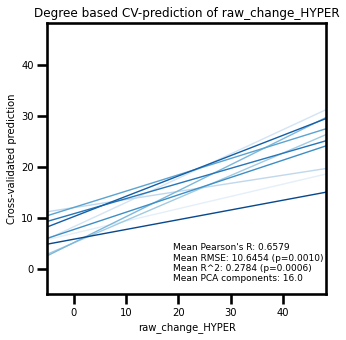

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.0050


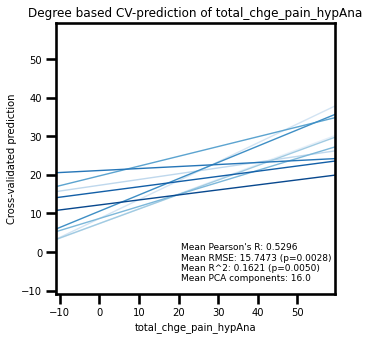

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.4225


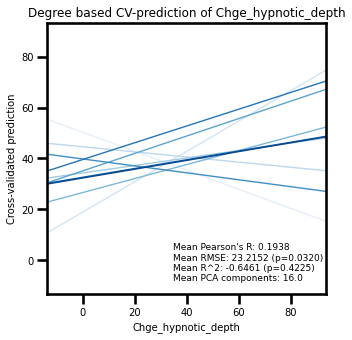

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.4653


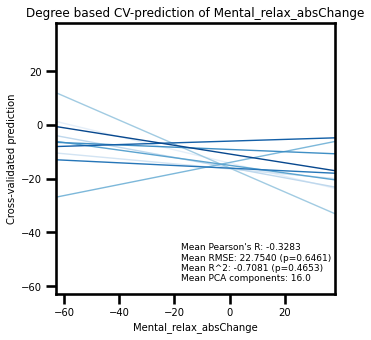

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.5979


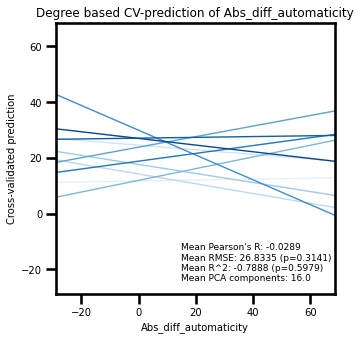

Closeness centrality
--- SHSS_score ---
Permutation test for r2 values: p=0.6847


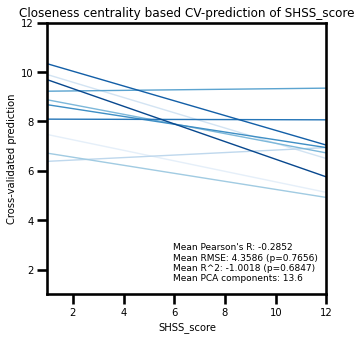

--- raw_change_ANA ---
Permutation test for r2 values: p=0.8774


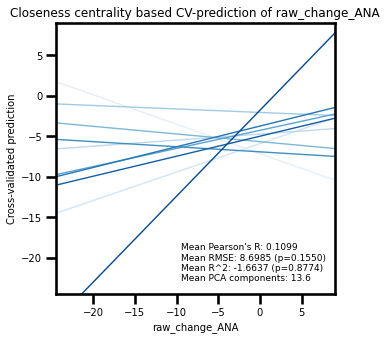

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.4095


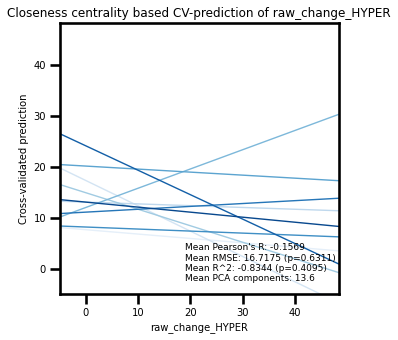

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.2633


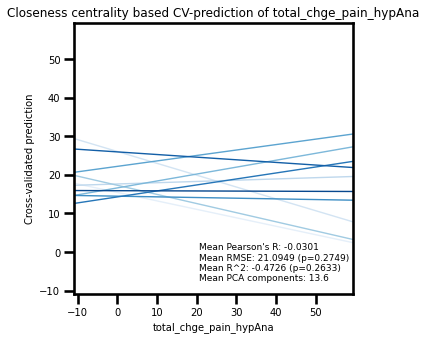

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.8766


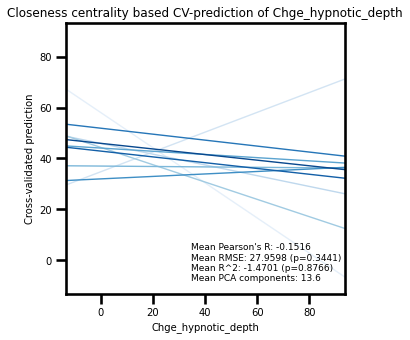

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.8246


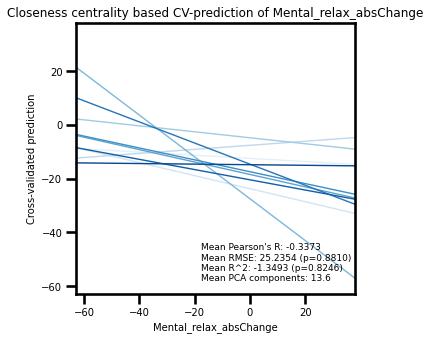

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.2721


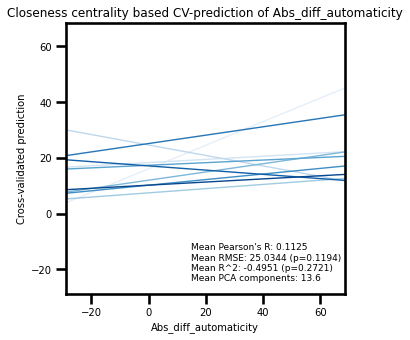

Betweenness centrality
--- SHSS_score ---
Permutation test for r2 values: p=0.7784


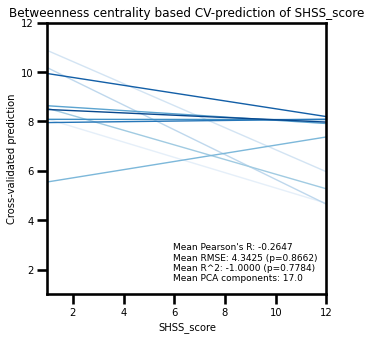

--- raw_change_ANA ---
Permutation test for r2 values: p=0.8420


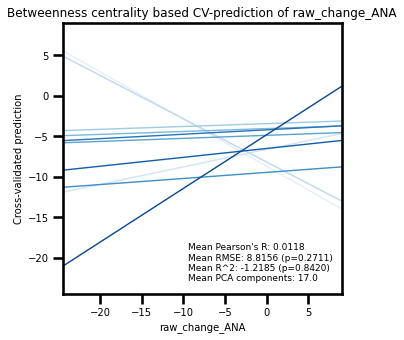

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.6041


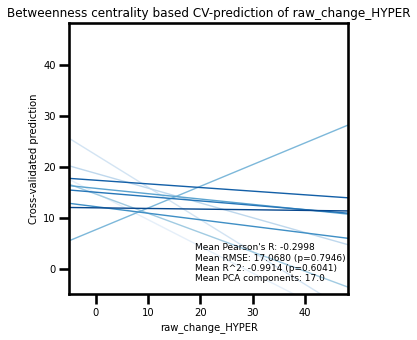

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.6667


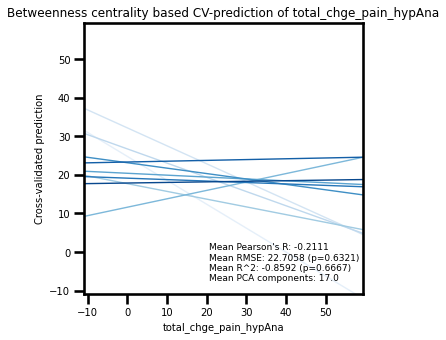

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.9750


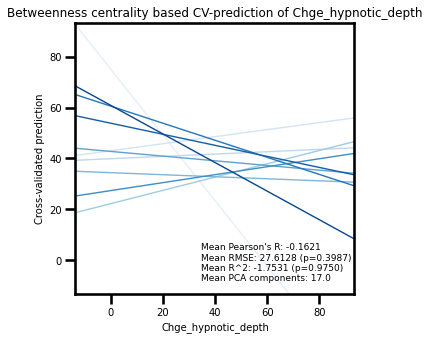

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.4043


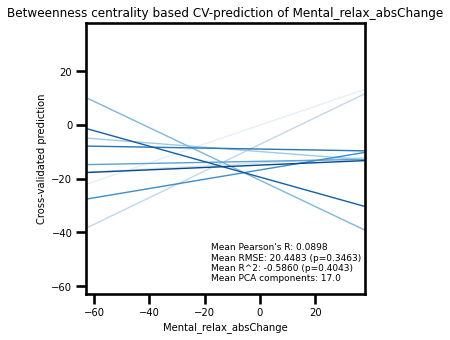

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.6793


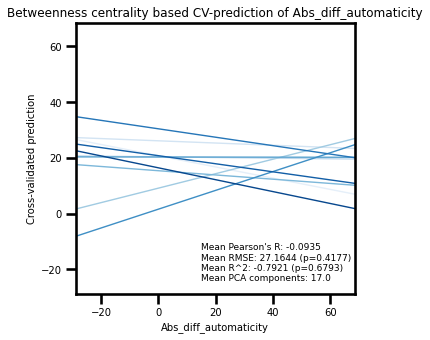

Clustering
--- SHSS_score ---
Permutation test for r2 values: p=0.6609


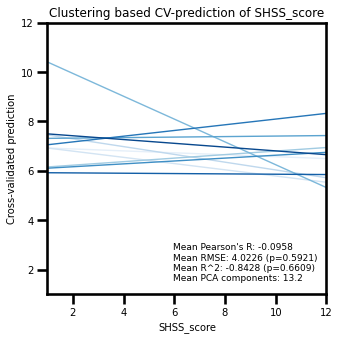

--- raw_change_ANA ---
Permutation test for r2 values: p=0.9012


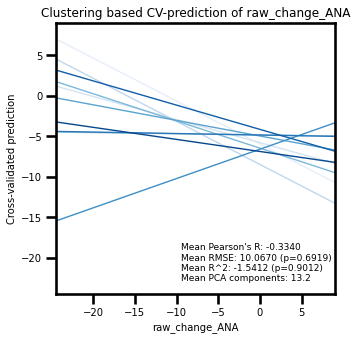

--- raw_change_HYPER ---
Permutation test for r2 values: p=0.3197


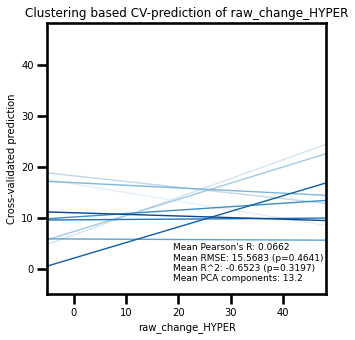

--- total_chge_pain_hypAna ---
Permutation test for r2 values: p=0.5347


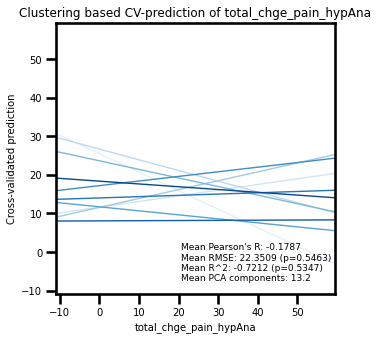

--- Chge_hypnotic_depth ---
Permutation test for r2 values: p=0.1004


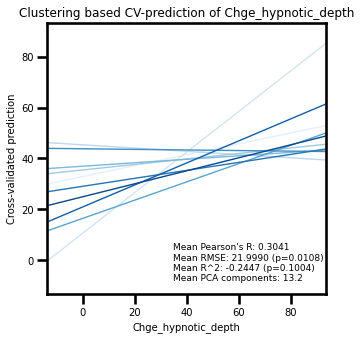

--- Mental_relax_absChange ---
Permutation test for r2 values: p=0.1272


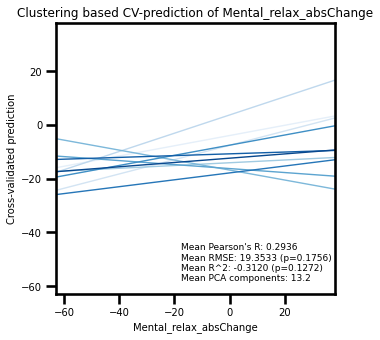

--- Abs_diff_automaticity ---
Permutation test for r2 values: p=0.3629


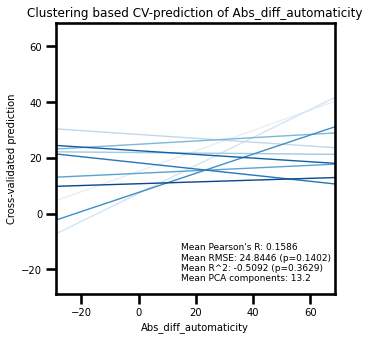

In [675]:
# Ridge model and output for each graph metric and dependent variable
#feature_matrices = [X_degree, X_degreeCentrality, X_closeness, X_betweenness, X_clustering]
#concatenated_matrices = np.vstack(feature_matrices)
#num_participants = X_degree.shape[0]
#group_column = np.tile(np.arange(1, num_participants + 1), len(feature_matrices))

random_seed = 0
for rawfeatures_matrix, g_metric in zip([X_con, X_degree, X_closeness, X_betweenness, X_clustering], ['Connectivity matrix', 'Degree', 'Closeness centrality', 'Betweenness centrality', 'Clustering']):
    print('================ \n{}\n================'.format(g_metric))
    
    prePipeline = Pipeline([('scaler', StandardScaler())])
    features_matrix = prePipeline.fit_transform(rawfeatures_matrix)

    #pipeline = Pipeline([('std', QuantileTransformer(n_quantiles=22)), ('pca', PCA(n_components=0.80)), ('ridge', Ridge())])
    pipeline = Pipeline([('pca', PCA(n_components=0.90)), ('reg', Ridge())])
    #cv = KFold(n_splits=5, random_state=random_seed, shuffle=True)
    cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=random_seed)

    for target_column in target_columns:
        print(f"--- {target_column} ---")
        y_preds = []
        y_tests = []
        y = Y[target_column].values
        # Add covariates to the feature matrix (?!!)
        add_cov = False
        #if  target_column != 'SHSS_score':
            #add_cov = True
            #covariate_column = 'SHSS_score'
        '''
        if target_column != 'SHSS_score':
            covariate_column = 'Abs_diff_automaticity'
            add_cov = True
        if add_cov:    
            features_matrix = np.hstack((features_matrix, Y[covariate_column].values.reshape(-1, 1)))
            covariate_corr, p_value = pearsonr(Y[covariate_column], y)
            p_value_corrected = fdrcorrection([p_value])[1][0]  # Apply FDR correction
            print(f"Pearson correlation between {covariate_column} and {target_column}:\n r={covariate_corr:.4f} (FDR corrected p-value: p={p_value_corrected:.4f})")
        '''
        
        pearson_r_scores = []
        r2_scores = []
        mse_scores = []
        rmse_scores = []
        n_components = []
        all_coefficients = []
        
        for train_index, test_index in cv.split(features_matrix):
            # Split the data into train and test sets based on the current fold
            X_train, X_test = features_matrix[train_index], features_matrix[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # Fit pipeline model with best hyperparameters
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_preds.append(y_pred)
            y_tests.append(y_test)

            # Calculate evaluation metrics
            pearson_r, _ = pearsonr(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)

            # Append metrics to the respective lists
            pearson_r_scores.append(pearson_r)
            r2_scores.append(r2)
            mse_scores.append(mse)
            rmse_scores.append(rmse)
            n_components.append(pipeline.named_steps['pca'].n_components_)
            coefficients = pipeline.named_steps['reg'].coef_
            all_coefficients.append(coefficients)

        #Permutation tests
        r2score, _, r2p_value = compute_permutation(features_matrix, y, pipeline, cv = cv, scoring='r2', random_seed=random_seed)
        rmse_score, _, rmse_p_value = compute_permutation(features_matrix, y, pipeline, cv = cv, scoring='neg_root_mean_squared_error', random_seed=random_seed)
        #r2p_value,rmse_p_value = 0.00001, 0.00001
        
        print(f"Permutation test for r2 values: p={r2p_value:.4f}")
        # Calculate mean metrics across all folds
        mean_pearson_r = np.mean(pearson_r_scores)
        mean_r2 = np.mean(r2_scores)
        mean_mse = np.mean(mse_scores)
        mean_rmse = np.mean(rmse_scores)
        mean_n_components = np.mean(n_components)
        # Calculate standard deviation metrics across all folds
        # avg_z_score = np.mean(np.array(all_coefficients), axis=0) / np.std(all_coefficients, axis=0)
        # print(f"Average z-score = {avg_z_score} std = {np.std(all_coefficients, axis=0)}")
        # Plot
        plot_title = f"{g_metric} based CV-prediction of {target_column}"
        reg_plot_performance(y_tests, y_preds, target_column, mean_pearson_r, mean_rmse, mean_r2, r2p_value,rmse_p_value, mean_n_components, title=plot_title)


In [ ]:
#Regular OLS model
from sklearn import datasets, linear_model
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, ShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection   
import statsmodels.api as sm

y_col = ["Abs_chge_pain_hypAna", "Chge_hypnotic_depth", "Mental_relax_absChange", "Abs_diff_automaticity"]


for col in y_col:
    y = Y[target_column].values
    x = PCA(n_components=10).fit_transform(X_con)
    lin_reg = sm.OLS(y, sm.add_constant(x)).fit()
    #lin_reg_log = sm.OLS(y_log, x_constant).fit()
    lin_reg_wls = sm.WLS(y, sm.add_constant(x)).fit()
    
    ols_res = lin_reg.summary()
    print(col, '\n-----------',ols_res)
    corr_ps = fdrcorrection(lin_reg.pvalues)[0]
    for i in range(len(corr_ps)):
        if corr_ps[i] == True:
            print('Feature', i, 'is significant with FDR correction')
    model = SVR()
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    print(cross_val_score(model, x, y, cv=ss))

        


### Classification

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


y = Y['SHSS_groups']
class_freq = y.value_counts().to_dict()
class_weight = {k: class_freq[k] for k in sorted(class_freq.keys())}

# Plot histogram of Y variable (SHSS groups)
plt.figure(figsize=(8, 6))
sns.histplot(data=y, kde=False, bins=len(y.unique()), color='blue')
plt.title(f'Histogram of SHSS Groups - {g_metric}')
plt.xlabel('SHSS Groups')
plt.ylabel('Frequency')
plt.show()

# Define classifiers
svc_clf = SVC(kernel='linear', C=1,class_weight = 'balanced',decision_function_shape = 'ovo',probability = True, random_state=42)
log_reg_clf = LogisticRegression(C=1, class_weight = 'balanced')
tree_clf = DecisionTreeClassifier(class_weight = 'balanced')

classifiers = [('svc', svc_clf), ('log_reg', log_reg_clf), ('tree', tree_clf)]

for features_matrix, g_metric in zip([X_con, X_degree, X_closeness, X_clustering], ['connectome','Degree', 'closeness', 'Clustering']):
    # Assuming X is your feature matrix and y is the 'SHSS_groups' column
    X = features_matrix
    voting_clf = VotingClassifier(estimators=classifiers, voting='hard')

    pipeline = Pipeline([('std', StandardScaler()), ('pca', PCA(n_components=0.80)), ('clf', voting_clf)])

    skf = StratifiedKFold(n_splits=5,shuffle= True, random_state=42)
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)
    scores = cross_val_score(pipeline, X, y, cv=skf)
    print('scores :', scores)
    # Calculate evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    print("---", g_metric, "---")
    print("Accuracy:",f"{accuracy:.4f}" )
    print("Precision:", f"{precision:.4f}")
    print("Recall:", f"{recall:.4f}")
    print("F1-score:", f"{f1:.4f}")

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:")
   # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {g_metric} prediction of SHSS groups')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

   

## Scale comparison

In [ ]:
resultspz, atlas, labels = load_all(p, 'difumo64_z_precision', 'difumo64') # z precision
resultspp, atlas, labels = load_all(p, 'difumo64_precision', 'difumo64') # psc precision
resultscovz, atlas, labels = load_all(p, 'difumo64_z_covariance', 'difumo64') # z covariance
resultscorz, atlas, labels = load_all(p, 'difumo64_z_correlation', 'difumo64') # z correlation (+arctanh correction)

In [ ]:
resultspz.keys()
# comparison of precisionz, precisionp, covz, corz
print('pre_mean_connectome', resultspz['pre_mean_connectome'].max(), '{:f}'.format(resultspp['pre_mean_connectome'].max()), resultscovz['pre_mean_connectome'].max(), resultscorz['pre_mean_connectome'].max())
print('post_mean_connectome', resultspz['post_mean_connectome'].max(), '{:f}'.format(resultspp['post_mean_connectome'].max()), resultscovz['post_mean_connectome'].max(), resultscorz['post_mean_connectome'].max())
print('zcontrast_mean_connectome', resultspz['zcontrast_mean_connectome'].max(), '{:f}'.format(resultspp['zcontrast_mean_connectome'].max()), resultscovz['zcontrast_mean_connectome'].max(), resultscorz['zcontrast_mean_connectome'].max())
print('pre_series', resultspz['pre_series'][0].max(), '{:f}'.format(resultspp['pre_series'][0].max()), resultscovz['pre_series'][0].max(), resultscorz['pre_series'][0].max())


# Graph theory (single graph)

In [ ]:
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import ttest_1samp

A = results['zcontrast_mean_connectome']
G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.Graph)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),labels)))
G.edges.data('weight')
edge_weights = G.edges.data('weight')


In [ ]:
# Get the basic structure and dimensions of the keys
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Nodes:", G.nodes())
print("Edges:", G.edges())

### Edge density plot

In [ ]:
# plot heatmap
#plt.figure(figsize = (20, 20))
#_ = sns.heatmap(A, cmap='coolwarm', cbar=True, square=False, mask=None)
matrix = A
matrixdiagNaN = matrix.copy()
np.fill_diagonal(matrixdiagNaN,np.nan)

# Weight distribution plot
bins = np.arange(np.sqrt(len(np.concatenate(matrix))))
bins = (bins - np.min(bins))/np.ptp(bins)
fig, axes = plt.subplots(1,2, figsize=(15,5))

# Distribution of raw weights
rawdist = sns.distplot(matrixdiagNaN.flatten(), bins=bins, kde=False, ax=axes[0], norm_hist=True)
rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

# Probability density of log10
log10dist = sns.distplot(np.log10(matrixdiagNaN).flatten(), kde=False, ax=axes[1], norm_hist=True)
log10dist.set(xlabel='log(weights)')

## Metrics

In [ ]:
import pygsp
G_fd = pygsp.graphs.Graph(A)
G_fd.compute_laplacian(lap_type="normalized")
G_fd.compute_fourier_basis()  # compute connectome harmonics

### Efficiency

In [ ]:

nx.global_efficiency(G)  # this gives efficiency for node 2 and 3


### Degree/Strength

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

# Compute the degree of the graph
degree = dict(G.degree(weight='weight'))

# Sort the nodes by degree (highest to lowest)
sorted_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)

# Get the highest 5% of nodes and their degree values
top_5_percent = int(len(sorted_degree) * 0.05)
highest_nodes = sorted_degree[:top_5_percent]

# Print all nodes and their degree values
print("Nodes sorted by degree (highest to lowest):")
for node_label, deg in sorted_degree:
    print(f"{node_label}: {deg}")

# Print the threshold value
threshold = highest_nodes[-1][1]
print(f"Threshold (highest 5%): {threshold}")

# Degree Histogram
sns.distplot(list(degree.values()), kde=False, norm_hist=False)
plt.xlabel('Degree Values')
plt.ylabel('Counts')

# Plot the highest 5% values on the histogram
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold (highest 5%)')
plt.legend()
plt.show()

# Plot the graph with degree values as the node markers
coords = plotting.find_probabilistic_atlas_cut_coords(atlas) 

# Plot the marker plot with all nodes
plt.figure(figsize=(8, 6))
plotting.plot_markers([degree[node] for node in G.nodes], coords, title='Node densities (correlation estim.) - All Nodes')
plt.show()

# Replace degree values below threshold with 0
for node_label, deg in degree.items():
    if deg < threshold:
        degree[node_label] = 0

# Plot the marker plot with only nodes above the threshold
plt.figure(figsize=(8, 6))
plotting.plot_markers([degree[node] for node in G.nodes], coords, title='Node densities (correlation estim.) - Nodes above Threshold')
plt.show()


In [ ]:
# degree
#Vertex degree quantifies the total number of vertex connections in an undirected binary network (Fornito et al. 2016)
G.degree(weight='weight')
strength = G.degree(weight='weight')
strengths = {node: val for (node, val) in strength}
nx.set_node_attributes(G, dict(strength), 'strength') # Add as nodal attribute

# Normalized node strength values 1/N-1
normstrenghts = {node: val * 1/(len(G.nodes)-1) for (node, val) in strength}
nx.set_node_attributes(G, normstrenghts, 'strengthnorm') # Add as nodal attribute

# Computing the mean degree of the network
normstrengthlist = np.array([val * 1/(len(G.nodes)-1) for (node, val) in strength])
mean_degree = np.sum(normstrengthlist)/len(G.nodes)
print('mean_degree :', mean_degree)
print(strengths)


### closeness

In [ ]:
# The function accepts a argument 'distance' that, in correlation-based networks, must be seen as the inverse ... 
# of the weight value. Thus, a high correlation value (e.g., 0.8) means a shorter distance (i.e., 0.2).
G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}

# Then add them as attributes to the graph edges
nx.set_edge_attributes(G, G_distance_dict, 'distance')

# Computation of Closeness closeness
closeness = nx.closeness_closeness(G, distance='distance')

# Now we add the closeness closeness value as an attribute to the nodes
nx.set_node_attributes(G, closeness, 'closecent')

# Closeness closeness Histogram
sns.distplot(list(closeness.values()), kde=False, norm_hist=False)
plt.xlabel('closeness Values')
plt.ylabel('Counts')

plotting.plot_markers([closeness[key] for key in sorted(closeness.keys())], coords)

print(['{} : {}'.format(node, G.nodes[node]['closecent']) for node in G.nodes if G.nodes[node]['closecent'] > 0.135])

Clossness closeness

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

# The function accepts a argument 'distance' that, in correlation-based networks, must be seen as the inverse ... 
# of the weight value. Thus, a high correlation value (e.g., 0.8) means a shorter distance (i.e., 0.2).
G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}

# Then add them as attributes to the graph edges
nx.set_edge_attributes(G, G_distance_dict, 'distance')

# Computation of Closeness closeness
closeness = nx.closeness_closeness(G, distance='distance')

# Now we add the closeness closeness value as an attribute to the nodes
nx.set_node_attributes(G, closeness, 'closecent')

# Sort the nodes by closeness closeness (highest to lowest)
sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

# Get the highest 5% of nodes and their closeness values
top_5_percent = int(len(sorted_closeness) * 0.05)
highest_nodes = sorted_closeness[:top_5_percent]

# Print all nodes and their closeness closeness values
print("Nodes sorted by closeness closeness (highest to lowest):")
for node_label, closeness in sorted_closeness:
    print(f"{node_label}: {closeness}")

# Print the threshold value
threshold = highest_nodes[-1][1]
print(f"Threshold (highest 5%): {threshold}")

# Closeness closeness Histogram
sns.distplot(list(closeness.values()), kde=False, norm_hist=False)
plt.xlabel('closeness Values')
plt.ylabel('Counts')

# Plot the highest 5% values on the histogram
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold (highest 5%)')
plt.legend()
plt.show()

# Plot the graph with closeness closeness values as the node markers
coords = plotting.find_probabilistic_atlas_cut_coords(atlas) 

# Plot the marker plot with all nodes
plt.figure(figsize=(8, 6))
plotting.plot_markers([closeness[node] for node in G.nodes], coords, title='Node densities (correlation estim.) - All Nodes')
plt.show()

# Replace closeness values below threshold with 0
for node_label, closeness in closeness.items():
    if closeness < threshold:
        closeness[node_label] = 0

# Plot the marker plot with only nodes above the threshold
plt.figure(figsize=(8, 6))
plotting.plot_markers([closeness[node] for node in G.nodes], coords, title='Node densities (correlation estim.) - Nodes above Threshold')
plt.show()


### Distance and shortest path

"The shortest path is the path with the least number of edges (or least total weight) between two vertices in a network. In a weighted graph, the shortest path is calculated by the minimum sum of the weights of edges between two vertices (Fornito et al. 2016). 
he weights must be converted to ‘distance’ by computing the inverse of the original weight (1−weight or 1weight); a higher correlation value represents a shorter distance (Fornito et al. 2016)"(Centeno,2022)

In [ ]:
# Distance
dist_dict = {(e1,e2): 1/abs(weight) for e1,e2 ,weight in G.edges.data('weight')}
nx.set_edge_attributes(G, dist_dict,'distance')

# Shortest path
short_path = dict(nx.all_pairs_dijkstra_path_length(G, weight='distance'))

In [ ]:
short_path

### *Clustering coefficient
The clustering coefficient assesses the tendency for any two neighbours of a vertex to be directly connected (or more strongly connected in the weighted case) to each other and can also be termed cliquishness (Hallquist and Hillary 2018)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

# Clustering Coefficient Calculation
clustering = nx.clustering(G, weight='weight')
nx.set_node_attributes(G, clustering, 'cc')

# Sort the nodes by clustering coefficient (highest to lowest)
sorted_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True)

# Get the highest 5% of nodes and their clustering coefficients
top_5_percent = int(len(sorted_clustering) * 0.05)
highest_nodes = sorted_clustering[:top_5_percent]

# Print all nodes and their clustering coefficients
print("Nodes sorted by clustering coefficient (highest to lowest):")
for node_label, cc in sorted_clustering:
    print(f"{node_label}: {cc}")

# Print the threshold value
threshold = highest_nodes[-1][1]
print(f"Threshold (highest 5%): {threshold}")

# Clustering Coefficient Histogram
plt.figure(figsize=(8, 6))
sns.distplot(list(clustering.values()), kde=False, norm_hist=False)
plt.xlabel('Clustering Coefficient')
plt.ylabel('Counts')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold (highest 5%)')
plt.legend()
plt.title('Clustering Coefficient Distribution')
plt.show()

# Plot the graph with clustering coefficients as the node markers
coords = plotting.find_probabilistic_atlas_cut_coords(atlas) 

# Plot the marker plot with all nodes
plt.figure(figsize=(8, 6))
plotting.plot_markers([clustering[node] for node in G.nodes], coords, title='Node Clustering Coefficients - All Nodes')
plt.show()

# Replace clustering coefficients values below threshold with 0
for node_label, cc in clustering.items():
    if cc < threshold:
        clustering[node_label] = 0

# Plot the marker plot with only nodes above the threshold
plt.figure(figsize=(8, 6))
plotting.plot_markers([clustering[node] for node in G.nodes], coords, title='Node Clustering Coefficients - Nodes above Threshold')
plt.show()


### ? *Modularity


In [ ]:
#part = nx.community.best_partition(G, weight='weight') # Louvain algorithm
from networkx import community
#part = community.best_partition(G, weight='weight')

# check number of communities
#set(part.values()).union()
communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
nx.community.modularity(G, top_level_communities)
top_level_communities


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Your code to generate the communities
communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
modularity = nx.community.modularity(G, top_level_communities)

# Create a dendrogram of the community structure
dendrogram = sch.dendrogram(sch.linkage(nx.to_numpy_array(G), method='ward'))

# Set plot labels and title
plt.xlabel('Nodes')
plt.ylabel('Distance')
plt.title('Dendrogram of Community Structure')

# Show the plot
plt.show()

# Create a bar plot to show the modularity of each community
community_modularities = [nx.community.modularity(G, community) for community in top_level_communities]
community_labels = [f'Community {i + 1}' for i in range(len(top_level_communities))]

plt.bar(community_labels, community_modularities)
plt.xlabel('Community')
plt.ylabel('Modularity')
plt.title('Modularity of Top-Level Communities')
plt.xticks(rotation=45)

# Show the plot
plt.show()


### Visualization

## Clustering

In [ ]:
lcc = nx.clustering(G, weight='weight')

In [ ]:
# minimum spanning tree
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

# Compute the minimum spanning tree
mst = nx.minimum_spanning_tree(G, weight='weight')

# Plot the MST on the brain template
coords = plotting.find_probabilistic_atlas_cut_coords(atlas) 

plt.figure(figsize=(8, 6))
plotting.plot_connectome(adjacency_matrix=nx.to_numpy_array(mst),
                         node_coords=coords,
                         node_color='skyblue',
                         edge_cmap='coolwarm',
                         edge_threshold='98%',
                         title='Minimum Spanning Tree (MST)')
plt.show()
